In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

import tensorflow as tf
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.models import model_from_json

from sklearn.model_selection import train_test_split
from sklearn import metrics

import wandb
from wandb.keras import WandbCallback

#custom packages
from models import createSimpleModel
from animate import *

In [2]:
print(tf.config.list_physical_devices('GPU'))
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


Referencing: https://arxiv.org/pdf/2212.11285.pdf

We start off by loading in 1,000,000 background dijet events and 100,000 signal dijet events. The signal comes from the process Z$\rightarrow$ X($\rightarrow$ $q\bar{q}$) Y$\rightarrow$($q\bar{q}$) where Z is 3.5 TeV. X is 500 GeV and Y is 100 GeV. 

In [41]:
dir_path = "/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5"
df_test = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection.h5")
df_test

,0,1,2,3,4,5,6,7,8,9,...,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100
0,0.324101,-0.361158,2.737669,0.409859,-2.429939,0.729830,0.867922,-2.267777,-1.161310,0.383031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.646304,-0.539460,-1.386258,0.471293,-1.636572,0.751657,0.453769,-1.099593,-0.393405,0.485929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.325172,-0.833948,2.404844,1.295058,-2.089618,-1.873342,0.451272,-0.101877,2.217348,0.461293,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.290918,-2.200063,1.630132,0.565028,-1.714345,-2.617103,0.951042,-0.532720,2.941473,0.896248,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.526330,-2.349110,-1.745532,0.542491,-2.080352,-3.044045,0.390727,-1.278563,-2.131058,2.530358,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099995,0.372368,-1.283898,2.680089,0.511526,-0.216247,1.011824,0.440795,-1.860590,1.395164,1.483386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099996,0.587996,-2.347485,0.104980,0.325682,-1.943584,-2.330028,0.700224,-2.161175,0.136797,0.550588,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099997,0.631419,-0.597308,-2.114541,3.165008,-0.968924,-0.729551,4.613834,-0.989630,-0.724770,3.701483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099998,5.084272,-1.004487,1.772670,4.767743,-0.878143,1.713857,10.833469,-0.934815,1.795471,10.265807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
df_QCD

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1467.239990,611.502014,511.101990,38.896000,8.290650,4.836080,4.260190,1403.579956,-674.551025,-451.670990,237.893997,79.815102,21.010300,16.757601
1,-1211.239990,347.315002,547.963013,389.532013,191.804001,99.562798,70.872200,619.341003,-62.177299,-1944.040039,22.999201,8.042180,6.335090,5.525370
2,-1229.619995,649.857971,8.089170,72.155502,47.168098,37.243198,33.658199,1196.250000,-647.896973,-1283.109985,78.230698,15.292900,13.944200,10.013500
3,-693.304016,-1046.729980,1716.910034,55.797798,24.788500,6.890140,5.813400,747.961975,994.250000,-412.966003,359.113007,175.209000,103.500999,84.447098
4,-1488.199951,-25.370100,-30.989700,84.891502,26.878799,15.517200,13.260400,1415.640015,20.905100,223.630997,77.506500,57.986000,34.147400,26.660601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,-646.442017,-1295.150024,1331.800049,37.011299,21.006800,12.873700,8.898860,274.566986,1019.390015,-504.290985,90.375000,61.218800,20.514500,15.854600
999995,-286.550995,-1310.829956,-1510.910034,147.516998,60.997799,41.356201,28.225700,252.884995,1085.420044,759.314026,58.769901,42.276402,8.637120,7.852020
999996,918.562988,951.195984,-1622.569946,32.242199,5.894110,5.004100,3.992740,-266.285004,-1284.189941,185.007996,136.389008,70.623901,49.508499,40.708599
999997,1447.219971,-547.710999,827.945007,396.112000,181.406998,152.207993,86.676804,-932.369995,165.005005,-2806.959961,56.471600,14.446400,10.258900,8.874700


In [7]:
def computemjj_pd(event):
    px1 = np.array(event['pxj1'])
    py1 = np.array(event['pyj1'])
    pz1 = np.array(event['pzj1'])
    mj1 = np.array(event['mj1'])
    Ej1 = np.sqrt((px1**2 + py1**2 + pz1**2) + mj1**2)

    px2 = np.array(event['pxj2'])
    py2 = np.array(event['pyj2'])
    pz2 = np.array(event['pzj2'])
    mj2 = np.array(event['mj2'])
    Ej2 = np.sqrt((px2**2 + py2**2 + pz2**2) + mj2**2)

    p4_j1 = np.array([px1, py1, pz1, Ej1]).transpose()
    p4_j2 = np.array([px2, py2, pz2, Ej2]).transpose()
    
    p4_jj = p4_j1 + p4_j2
    mjj = np.sqrt((p4_jj**2 * np.array([-1, -1, -1, 1])).sum(axis=1))
    return mjj

In [9]:
mjj

array([3307.21938744, 3107.62060343, 3004.89527209, ..., 3021.08344341,
       4283.54500244, 2784.05801619])

In [15]:
df = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")

In [16]:
df

,pxj1,pyj1,pzj1,mj1,tau1j1,tau2j1,tau3j1,pxj2,pyj2,pzj2,mj2,tau1j2,tau2j2,tau3j2
0,-1698.670044,-884.039978,723.843018,105.035004,83.721703,46.282101,13.635700,1539.439941,372.238007,-295.865997,461.574005,431.343994,52.344799,37.284901
1,1246.660034,-1133.010010,-921.987000,159.865997,133.781998,58.968601,30.377399,-1218.489990,1108.380005,182.147003,514.883972,462.654999,138.789001,67.805801
2,420.975006,-1739.790039,281.553986,93.665901,77.925797,10.605900,6.916520,-510.779999,1484.069946,227.175995,475.316986,217.113998,29.424000,21.020300
3,161.048996,-1664.859985,-2005.099976,116.327003,61.819698,38.143600,18.414400,-188.942993,1556.900024,-561.664001,561.236023,348.181000,102.625000,53.422699
4,-564.754028,-1315.599976,-1087.410034,513.015991,276.446991,50.629799,35.460999,326.164001,1050.239990,1201.000000,108.752998,89.666603,40.928699,17.055799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99994,-206.662003,-1729.280029,357.635010,96.165001,58.014500,11.731300,6.174070,218.800003,1714.890015,-210.578995,472.475006,259.884003,40.806999,31.226000
99995,1069.660034,659.874023,218.751007,126.183998,122.486000,27.608700,17.924801,-956.169006,-297.311005,-2204.350098,108.890999,21.177200,10.582400,9.138590
99996,-1286.619995,-86.162598,-1366.270020,115.719002,109.853996,29.830200,22.489201,1145.729980,136.792007,1216.780029,489.053009,416.747009,84.599998,66.767502
99997,-149.330002,1781.459961,-58.690899,508.045013,495.290985,82.283600,43.567902,84.726601,-1378.569946,-1485.469971,91.104897,79.120102,46.537300,23.227301


Text(0.5, 1.0, 'Jet Mass Distributions')

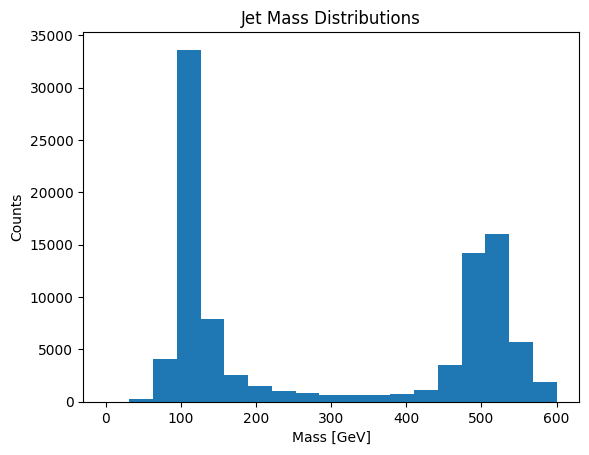

In [65]:
plt.hist(df['mj1'],bins=np.linspace(0,600,20))
plt.xlabel("Mass [GeV]")
plt.ylabel("Counts")
plt.title("Jet Mass Distributions")

In [112]:
# def computemjj_pd(event):
#     px1 = event[["pxj1"]].to_numpy()
#     py1 = event[["pyj1"]].to_numpy()
#     pz1 = event[["pzj1"]].to_numpy()
#     pE1 = np.sqrt(px1**2+py1**2+pz1**2+event[["mj1"]].to_numpy()**2)
    
#     px2 = event[["pxj2"]].to_numpy()
#     py2 = event[["pyj2"]].to_numpy()
#     pz2 = event[["pzj2"]].to_numpy()
#     pE2 = np.sqrt(px2**2+py2**2+pz2**2+event[["mj2"]].to_numpy()**2)
    
#     m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
#     return np.array(np.sqrt(m2)).flatten()

In [115]:
computemjj_pd(df_QCD)

/tmp/ipykernel_340405/3658239227.py:13: RuntimeWarning: invalid value encountered in sqrt
  return np.array(np.sqrt(m2)).flatten()


array([3355.02554618, 2339.42558763, 2476.53829533, ..., 3867.9955467 ,
       2882.70480346, 2279.14046694])

In [50]:
def computemjj_txt(event):
    pT1 = np.array([float(event[2*i][0]) for i in range(int(len(event)/2))])
    eta1 = np.array([float(event[2*i][1]) for i in range(int(len(event)/2))])
    phi1 = np.array([float(event[2*i][2]) for i in range(int(len(event)/2))])
    m1 = np.array([float(event[2*i][3]) for i in range(int(len(event)/2))])
    px1 = pT1*np.cos(phi1)
    py1 = pT1*np.sin(phi1)
    pz1 = pT1*np.sinh(eta1)
    pE1 = np.sqrt(px1**2+py1**2+pz1**2+m1**2)
    
    pT2 = np.array([float(event[2*i+1][0]) for i in range(int(len(event)/2))])
    eta2 = np.array([float(event[2*i+1][1]) for i in range(int(len(event)/2))])
    phi2 = np.array([float(event[2*i+1][2]) for i in range(int(len(event)/2))])
    m2 = np.array([float(event[2*i+1][3]) for i in range(int(len(event)/2))])
    px2 = pT2*np.cos(phi2)
    py2 = pT2*np.sin(phi2)
    pz2 = pT2*np.sinh(eta2)
    pE2 = np.sqrt(px2**2+py2**2+pz2**2+m2**2)
    
    m2 = (pE1+pE2)**2-(px1+px2)**2-(py1+py2)**2-(pz1+pz2)**2
    return np.array(np.sqrt(m2)).flatten()

In [3]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]

epsilon = 1e-6
if (False):
    lmass_vec = {}
    x = {}
    mjjs = {}

    mu_m = 0.
    mu_t = 0.
    sd_m = 0.
    sd_t = 0.

    for m1 in mass_range:
        for m2 in mass_range:

            print("on ...",m1,m2)

            ltau1_m_m = []
            ltau2_m_m = []
            stau1_m_m = []
            stau2_m_m = []
            if (m1>0 and m2>0):
                myfile = open("/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq/LHCO_RnD_qq_"+str(int(m1*100))+"_"+str(int(100*m2))+".txt")
                jets_m_m = []
                for line in myfile:
                    jets_m_m+=[line.split("J")[1].split("P")[0].split()]
                    pass
                                    
                ljet_m_m = [jets_m_m[2*n] for n in range(int(len(jets_m_m)/2))]
                sjet_m_m = [jets_m_m[2*n+1] for n in range(int(len(jets_m_m)/2))]

                lmass_m_m = np.array([float(ljet_m_m[i][3]) for i in range(len(ljet_m_m))])/1000.
                smass_m_m = np.array([float(sjet_m_m[i][3]) for i in range(len(sjet_m_m))])/1000.

                #check ordering of the leading and subleading jets
                #if leading jet mm > subleading, continue
                #if leading jet mm < subleading, swap
                for i in range(int(len(lmass_m_m))):
                    if lmass_m_m[i] > smass_m_m[i]:
                        continue
                    elif lmass_m_m[i] < smass_m_m[i]:
                        lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                
                ltau1_m_m = np.array([float(ljet_m_m[i][5]) for i in range(len(ljet_m_m))])
                ltau2_m_m = np.array([float(ljet_m_m[i][6]) for i in range(len(ljet_m_m))])

                stau1_m_m = np.array([float(sjet_m_m[i][5]) for i in range(len(ljet_m_m))])
                stau2_m_m = np.array([float(sjet_m_m[i][6]) for i in range(len(ljet_m_m))])

                mjj = computemjj_txt(jets_m_m)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]
                pass
            elif m1==0 and m2==0:
                df_QCD = pd.read_hdf("/global/cfs/projectdirs/m3246/AnomalyDetection/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")
                lmass_m_m = np.array(df_QCD[["mj1"]]).flatten()/1000.
                smass_m_m = np.array(df_QCD[["mj2"]]).flatten()/1000.
                
                #check jet ordering
                for i in range(int(len(lmass_m_m))):
                    if lmass_m_m[i] > smass_m_m[i]:
                        continue
                    elif lmass_m_m[i] < smass_m_m[i]:
                        lmass_m_m[i], smass_m_m[i] = smass_m_m[i], lmass_m_m[i]
                        
                ltau1_m_m = np.array(df_QCD[["tau1j1"]]).flatten()
                ltau2_m_m = np.array(df_QCD[["tau2j1"]]).flatten()
                stau1_m_m = np.array(df_QCD[["tau1j2"]]).flatten()
                stau2_m_m = np.array(df_QCD[["tau2j2"]]).flatten()
                mjj = computemjj_pd(df_QCD)/1000.
                mjjs[m1,m2] = mjj
                passcut = (mjj > 3.3) * (mjj < 3.7)
                lmass_m_m = lmass_m_m[passcut]
                smass_m_m = smass_m_m[passcut]
                ltau1_m_m = ltau1_m_m[passcut]
                ltau2_m_m = ltau2_m_m[passcut]
                stau1_m_m = stau1_m_m[passcut]
                stau2_m_m = stau2_m_m[passcut]

                mu_m = np.mean(lmass_m_m)
                mu_t = np.mean(ltau2_m_m/(ltau1_m_m+epsilon))
                sd_m = np.std(lmass_m_m)
                sd_t = np.std(ltau2_m_m/(ltau1_m_m+epsilon))
                pass
            else:
                continue

            ms = np.stack([lmass_m_m,smass_m_m],axis=1)
            ts = np.stack([ltau2_m_m/(ltau1_m_m+epsilon),stau2_m_m/(stau1_m_m+epsilon)],axis=1)
            order1 = [np.argmax(ms[i]) for i in range(len(ms))]
            order2 = [np.argmin(ms[i]) for i in range(len(ms))]
            mJ1 = np.array([ms[i][order1[i]] for i in range(len(ms))])
            mJ2 = np.array([ms[i][order2[i]] for i in range(len(ms))])
            x[m1,m2] = np.stack([(mJ2 - mu_m)/sd_m,
                                    ((mJ1 - mJ2) - mu_m)/sd_m,
                                    ([ts[i][order2[i]] for i in range(len(ts))] - mu_t)/sd_t,
                                    ([ts[i][order1[i]] for i in range(len(ts))] - mu_t)/sd_t],axis=1)
            lmass_vec[m1,m2]=lmass_m_m
            pass
        pass

    x_array = []
    for m1 in mass_range:
        for m2 in mass_range:
            if (m1==0 and m2>0 or m2==0 and m1>0):
                continue
            x_array+=[x[m1,m2]]
    np.save("x_array_order1", x_array)

In [4]:
x = {}
x_array_read = np.load("x_array_order.npy",allow_pickle=True)
mycounter = -1
for m1 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
    for m2 in [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [5]:
np.shape(x[0,0])

(121352, 4)

In [6]:
x_data_100 = np.concatenate([x[0,0],x[1,1]])
y_data_100 = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[1,1]))])
X_train_100, X_val_100, Y_train_100, Y_val_100 = train_test_split(x_data_100, y_data_100, test_size=0.5)

In [48]:
pscratch_dir = "/pscratch/sd/g/gupsingh"
os.environ["WANDB_DIR"] = pscratch_dir

wandb.init(
    project="Anomaly",
    group="Dedicated_Fixed",
    entity='gup-singh',
    mode = 'online',

    config={
        "layer_1": 512,
        "activation_1": "relu",
        "layer_2": 256,
        "activation_2": "relu",
        "layer_3": 128,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 1000,
        "batch_size": 1024,
    },
    dir=pscratch_dir
)

config = wandb.config

In [49]:
model_dedicated = Sequential()
model_dedicated.add(Dense(config.layer_1, input_dim=4, activation=config.activation_1))
#model_dedicated.add(Dropout(config.dropout_rate_1))
model_dedicated.add(Dense(config.layer_2, activation=config.activation_2))
model_dedicated.add(Dense(config.layer_3, activation=config.activation_3))
model_dedicated.add(Dense(config.output_layer, activation=config.output_activation))
model_dedicated.compile(loss=config.loss, optimizer=config.optimizer, metrics=[config.metric])
model_dedicated.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 512)               2560      
                                                                 
 dense_29 (Dense)            (None, 256)               131328    
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 dense_31 (Dense)            (None, 1)                 129       
                                                                 
Total params: 166,913
Trainable params: 166,913
Non-trainable params: 0
_________________________________________________________________


In [50]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [51]:
myhistory = model_dedicated.fit(X_train_100, Y_train_100, epochs=config.epoch,
                                validation_data=(X_val_100, Y_val_100),
                                batch_size=config.batch_size, callbacks=[WandbCallback(), es])

Epoch 1/1000
68/97 [====================>.........] - ETA: 0s - loss: 0.1063 - accuracy: 0.8560INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 10ms/step - loss: 0.0997 - accuracy: 0.8657 - val_loss: 0.0822 - val_accuracy: 0.8896
Epoch 2/1000
66/97 [===================>..........] - ETA: 0s - loss: 0.0794 - accuracy: 0.8944INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.0782 - accuracy: 0.8952 - val_loss: 0.0737 - val_accuracy: 0.9015
Epoch 3/1000
88/97 [==========================>...] - ETA: 0s - loss: 0.0689 - accuracy: 0.9063INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.0689 - accuracy: 0.9061 - val_loss: 0.0644 - val_accuracy: 0.9111
Epoch 4/1000
66/97 [===================>..........] - ETA: 0s - loss: 0.0650 - accuracy: 0.9105INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.0638 - accuracy: 0.9123 - val_loss: 0.0608 - val_accuracy: 0.9160
Epoch 5/1000
67/97 [===================>..........] - ETA: 0s - loss: 0.0620 - accuracy: 0.9151INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.0619 - accuracy: 0.9148 - val_loss: 0.0604 - val_accuracy: 0.9166
Epoch 6/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0619 - accuracy: 0.9143 - val_loss: 0.0614 - val_accuracy: 0.9147
Epoch 7/1000
65/97 [===================>..........] - ETA: 0s - loss: 0.0613 - accuracy: 0.9151INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.0615 - accuracy: 0.9151 - val_loss: 0.0598 - val_accuracy: 0.9168
Epoch 8/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0611 - accuracy: 0.9157 - val_loss: 0.0619 - val_accuracy: 0.9138
Epoch 9/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0611 - accuracy: 0.9156 - val_loss: 0.0602 - val_accuracy: 0.9161
Epoch 10/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0616 - accuracy: 0.9151 - val_loss: 0.0610 - val_accuracy: 0.9161
Epoch 11/1000
93/97 [===========================>..] - ETA: 0s - loss: 0.0609 - accuracy: 0.9155INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 9ms/step - loss: 0.0609 - accuracy: 0.9155 - val_loss: 0.0597 - val_accuracy: 0.9174
Epoch 12/1000
66/97 [===================>..........] - ETA: 0s - loss: 0.0615 - accuracy: 0.9147INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 13ms/step - loss: 0.0606 - accuracy: 0.9162 - val_loss: 0.0595 - val_accuracy: 0.9177
Epoch 13/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0609 - accuracy: 0.9157 - val_loss: 0.0596 - val_accuracy: 0.9174
Epoch 14/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0607 - accuracy: 0.9163 - val_loss: 0.0601 - val_accuracy: 0.9168
Epoch 15/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0605 - accuracy: 0.9163 - val_loss: 0.0600 - val_accuracy: 0.9168
Epoch 16/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0609 - accuracy: 0.9156 - val_loss: 0.0601 - val_accuracy: 0.9168
Epoch 17/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0605 - accuracy: 0.9161 - val_loss: 0.0606 - val_accuracy: 0.9158
Epoch 18/1000
88/97 [==========================>...] - ETA: 0s - loss: 0.0609 - accuracy: 0.9153INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/

wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231116_203913-vfc4jn72/files/model-best)... Done. 0.0s


97/97 [==============================] - 1s 10ms/step - loss: 0.0608 - accuracy: 0.9156 - val_loss: 0.0594 - val_accuracy: 0.9175
Epoch 19/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0607 - accuracy: 0.9165 - val_loss: 0.0601 - val_accuracy: 0.9165
Epoch 20/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0604 - accuracy: 0.9166 - val_loss: 0.0597 - val_accuracy: 0.9174
Epoch 21/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0604 - accuracy: 0.9162 - val_loss: 0.0598 - val_accuracy: 0.9173
Epoch 22/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0603 - accuracy: 0.9166 - val_loss: 0.0606 - val_accuracy: 0.9157
Epoch 23/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0604 - accuracy: 0.9163 - val_loss: 0.0601 - val_accuracy: 0.9167
Epoch 24/1000
97/97 [==============================] - 0s 3ms/step - loss: 0.0601 - accuracy: 0.9167 - val_loss: 0.0596 - val_accuracy: 0.9173
Epoch 25/100

In [52]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▅▆▇████████████████████████
epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆██▇█▇█████████████▇██████
val_loss,█▅▃▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.91676
best_epoch,17
best_val_loss,0.05944
epoch,27
loss,0.06022
val_accuracy,0.91689


In [7]:
model_dedicated = Sequential()
model_dedicated.add(Dense(128, input_dim=4, activation='relu'))
model_dedicated.add(Dense(128, activation='relu'))
model_dedicated.add(Dense(128, activation='relu'))
model_dedicated.add(Dense(1, activation='sigmoid'))
model_dedicated.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

2023-11-15 14:26:47.851303: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 14:26:48.528032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12293 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [9]:
myhistory = model_dedicated.fit(X_train_100, Y_train_100, epochs=100,validation_data=(X_val_100, Y_val_100),batch_size=1024)

Epoch 1/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1931 - accuracy: 0.9190 - val_loss: 0.1905 - val_accuracy: 0.9201
Epoch 2/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1921 - accuracy: 0.9194 - val_loss: 0.1890 - val_accuracy: 0.9206
Epoch 3/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1920 - accuracy: 0.9198 - val_loss: 0.1891 - val_accuracy: 0.9208
Epoch 4/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1929 - accuracy: 0.9191 - val_loss: 0.1888 - val_accuracy: 0.9213
Epoch 5/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1918 - accuracy: 0.9199 - val_loss: 0.1884 - val_accuracy: 0.9211
Epoch 6/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1925 - accuracy: 0.9190 - val_loss: 0.1893 - val_accuracy: 0.9207
Epoch 7/100
193/193 [==============================] - 0s 2ms/step - loss: 0.1919 - accuracy: 0.9195 - val_loss: 0.1883 - val_accuracy: 0.9206

In [34]:
wandb.finish()

In [53]:
#model_dedicated.save("model_100_BCE")
#model.save("model_MSE")

INFO:tensorflow:Assets written to: model_100_BCE/assets


In [59]:
preds_mm_list = []

tuple_rates_dedicated_ordered_BCE = {}

for i in mass_range[1:]:
    for j in mass_range[1:]:
        if (i == 0.5 and j == 0.5) or (i == 1 and j == 1) or (i == 3 and j == 3) or (i == 6 and j == 6):
            print(i,j)
            x_vals_mm = np.concatenate([x[0,0],x[i,j]])
            y_vals_mm = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[i,j]))])
            X_train_mm, X_val_mm, Y_train_mm, Y_val_mm = train_test_split(x_vals_mm, y_vals_mm, test_size=0.5)

            model = Sequential()
            model.add(Dense(512, input_dim=4, activation='relu'))
            model.add(Dense(256, activation='relu'))
            model.add(Dense(128, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

            myhistory = model.fit(X_train_mm, Y_train_mm, epochs=1000, validation_data=(X_val_mm, Y_val_mm),batch_size=1024, callbacks = [es])

            preds_mm = model.predict(X_val_mm,batch_size=1000)
            fpr_mm, tpr_mm, _ = metrics.roc_curve(Y_val_mm, preds_mm)

            preds_mm_list.append(preds_mm)
            tuple_rates_dedicated_BCE[tuple((i, j))] = [fpr_mm, tpr_mm]

0.5 0.5
Epoch 1/1000
192/192 [==============================] - 2s 6ms/step - loss: 0.2920 - accuracy: 0.8740 - val_loss: 0.2710 - val_accuracy: 0.8852
Epoch 2/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2666 - accuracy: 0.8874 - val_loss: 0.2613 - val_accuracy: 0.8931
Epoch 3/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2588 - accuracy: 0.8922 - val_loss: 0.2572 - val_accuracy: 0.8919
Epoch 4/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2567 - accuracy: 0.8930 - val_loss: 0.2545 - val_accuracy: 0.8939
Epoch 5/1000
192/192 [==============================] - 1s 6ms/step - loss: 0.2557 - accuracy: 0.8927 - val_loss: 0.2544 - val_accuracy: 0.8944
Epoch 6/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2555 - accuracy: 0.8927 - val_loss: 0.2522 - val_accuracy: 0.8950
Epoch 7/1000
192/192 [==============================] - 1s 5ms/step - loss: 0.2553 - accuracy: 0.8933 - val_loss: 0.2530 - val_a

In [60]:
len(tuple_rates_dedicated_BCE_Optimized)

4

In [61]:
# np.save("fpr_mm", fpr_mm_list)
# np.save("tpr_mm", tpr_mm_list)
np.save("tuple_rates_dedicated_BCE", tuple_rates_dedicated_BCE)

#fpr_mm_list = np.load("fpr_mm.npy", allow_pickle = True)

In [62]:
model_all_BCE = tf.keras.models.load_model('model_all_BCE')

In [114]:
tuple_rates_dedicated = np.load("tuple_rates_dedicated.npy", allow_pickle = True).item()
len(tuple_rates_dedicated)

144

In [65]:
preds_all_BCE_50 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[0.5,0.5],axis=1)==1],batch_size=1000)
fpr_all_BCE_50, tpr_all_BCE_50, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[0.5,0.5],axis=1)==1], preds_all_BCE_50)

99/99 [==============================] - 0s 756us/step


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


91/91 [==============================] - 0s 2ms/step


/tmp/ipykernel_46945/334003819.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))


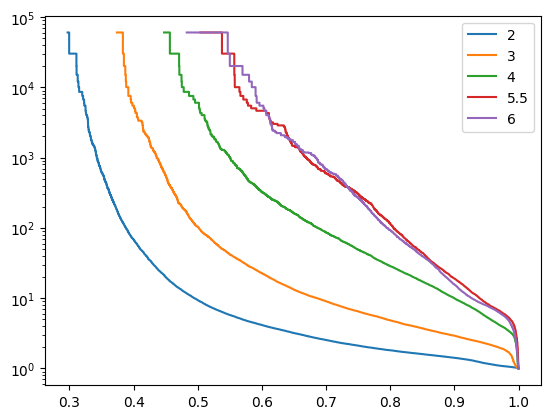

In [181]:
for m in [2, 3, 4, 5.5, 6]:
    something = X_val_all[np.product(X_val_all[:,4:6]==[4.5,6],axis=1)==1]
    something[:,4:6]= np.c_[np.ones(len(something)) * m, np.ones(len(something)) * m]
    preds_all_BCE_50 = model_all_BCE.predict(something,batch_size=1000)
    fpr_all_BCE_50, tpr_all_BCE_50, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[4.5,6],axis=1)==1], preds_all_BCE_50)
    plt.plot(tpr_all_BCE_50, 1/fpr_all_BCE_50, label = str(m))
    plt.legend()
    plt.yscale("log")

In [174]:
np.shape(np.c_[np.ones(len(something)) * 3, np.ones(len(something)) * 3])

(98560, 2)

In [172]:
np.shape(something[:,4:6])

(98560, 2)

In [63]:
preds_all_BCE_100 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_BCE_100, tpr_all_BCE_100, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_BCE_100)

preds_all_BCE_200 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[2,2],axis=1)==1],batch_size=1000)
fpr_all_BCE_200, tpr_all_BCE_200, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[2,2],axis=1)==1], preds_all_BCE_200)

preds_all_BCE_300 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[3,3],axis=1)==1],batch_size=1000)
fpr_all_BCE_300, tpr_all_BCE_300, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[3,3],axis=1)==1], preds_all_BCE_300)

preds_all_BCE_400 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[4,4],axis=1)==1],batch_size=1000)
fpr_all_BCE_400, tpr_all_BCE_400, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[4,4],axis=1)==1], preds_all_BCE_400)

preds_all_BCE_500 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[5,5],axis=1)==1],batch_size=1000)
fpr_all_BCE_500, tpr_all_BCE_500, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[5,5],axis=1)==1], preds_all_BCE_500)

preds_all_BCE_600 = model_all_BCE.predict(X_val_all[np.product(X_val_all[:,4:6]==[6,6],axis=1)==1],batch_size=1000)
fpr_all_BCE_600, tpr_all_BCE_600, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[6,6],axis=1)==1], preds_all_BCE_600)

87/87 [==============================] - 0s 757us/step


In [64]:
tuple_rates_dedicated_BCE_Optimized.keys()

dict_keys([(0.5, 0.5), (1, 1), (3, 3), (6, 6)])

Text(0.5, 1.0, '$(600,600)$ GeV Dedicated vs Parametrized BCE')

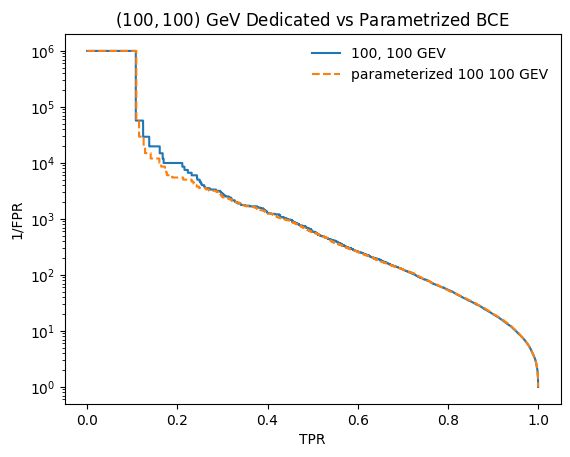

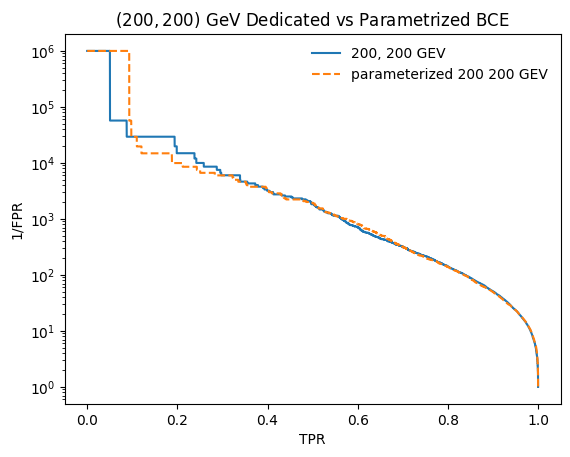

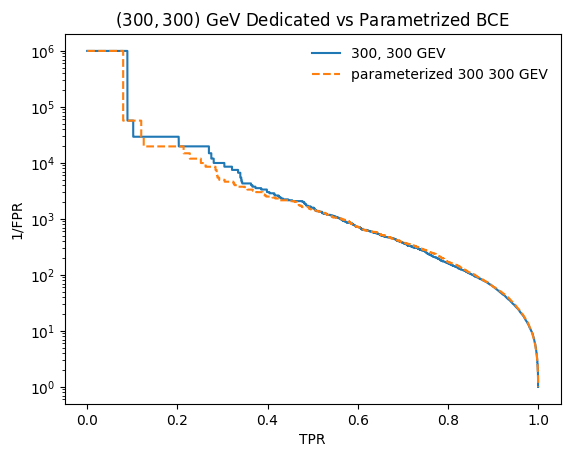

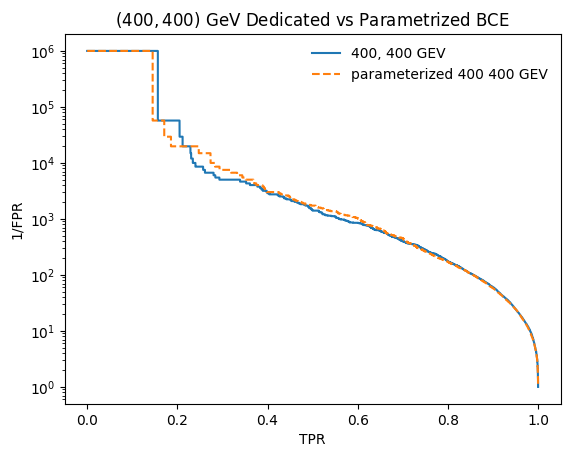

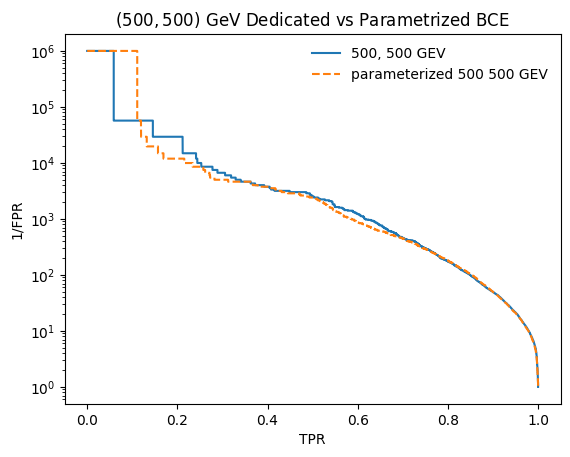

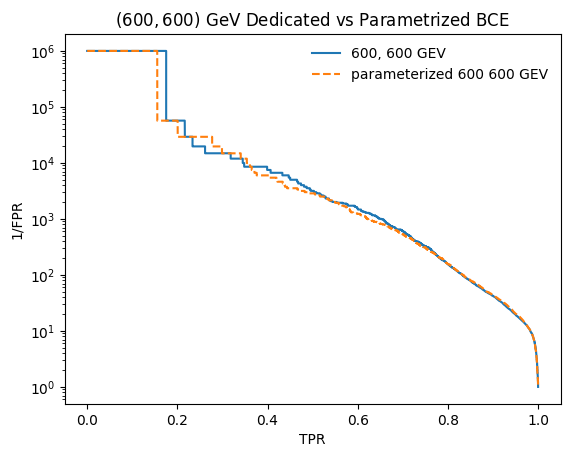

In [116]:
epsilon = 1e-6
plt.figure()
plt.plot(tuple_rates_dedicated[(1,1)][1], 1./(tuple_rates_dedicated[(1,1)][0] + epsilon), label = "100, 100 GEV")
plt.plot(tpr_all_BCE_100, 1./(fpr_all_BCE_100 + epsilon),label="parameterized 100 100 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(100,100)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(2,2)][1], 1./(tuple_rates_dedicated[(2,2)][0] + epsilon), label = "200, 200 GEV")
plt.plot(tpr_all_BCE_200, 1./(fpr_all_BCE_200 + epsilon),label="parameterized 200 200 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(200,200)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(3,3)][1], 1./(tuple_rates_dedicated[(3,3)][0] + epsilon), label = "300, 300 GEV")
plt.plot(tpr_all_BCE_300, 1./(fpr_all_BCE_300 + epsilon),label="parameterized 300 300 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(300,300)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(4,4)][1], 1./(tuple_rates_dedicated[(4,4)][0] + epsilon), label = "400, 400 GEV")
plt.plot(tpr_all_BCE_400, 1./(fpr_all_BCE_400 + epsilon),label="parameterized 400 400 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(400,400)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(5,5)][1], 1./(tuple_rates_dedicated[(5,5)][0] + epsilon), label = "500, 500 GEV")
plt.plot(tpr_all_BCE_500, 1./(fpr_all_BCE_500 + epsilon),label="parameterized 500 500 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(500,500)$ GeV Dedicated vs Parametrized BCE")

plt.figure()
plt.plot(tuple_rates_dedicated[(6,6)][1], 1./(tuple_rates_dedicated[(6,6)][0] + epsilon), label = "600, 600 GEV")
plt.plot(tpr_all_BCE_600, 1./(fpr_all_BCE_600 + epsilon),label="parameterized 600 600 GEV", linestyle='dashed')
plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(600,600)$ GeV Dedicated vs Parametrized BCE")

Analysis of Models begins here

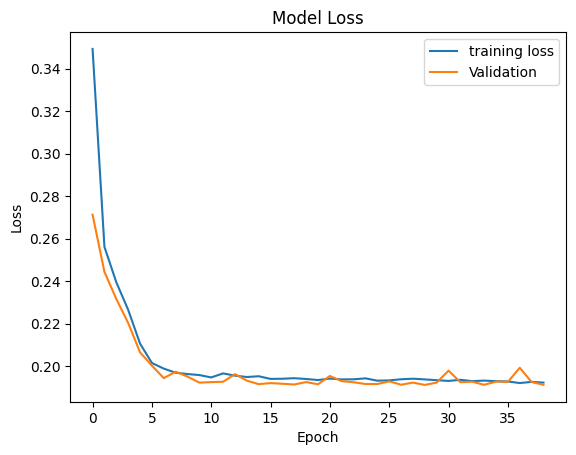

In [153]:
# Plot the training and validation loss
plt.plot(myhistory.history['loss'])
plt.plot(myhistory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training loss', 'Validation'], loc='upper right')
plt.show()

In [89]:
preds_100 = model.predict(X_val_100,batch_size=1000)
fpr_100, tpr_100, _ = metrics.roc_curve(Y_val_100, preds_100)

99/99 [==============================] - 0s 737us/step


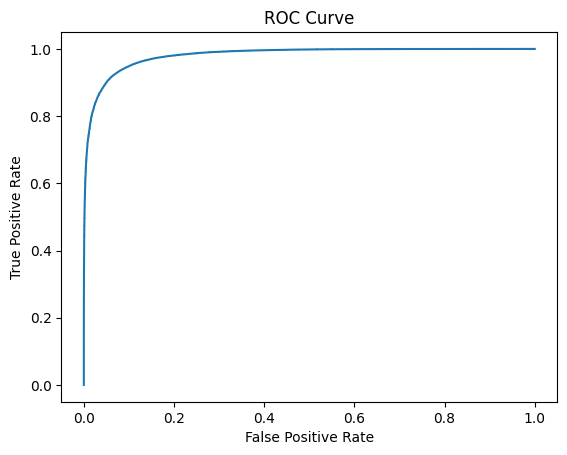

In [79]:
plt.plot(1-tpr_100, 1-fpr_100)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [13]:
if (False):
    x_vals_all = []
    y_vals_all = []
    for m1 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
        for m2 in [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]:
            print(m1,m2)
            x_aug_0 = np.append(np.append(x[0,0],m1*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1),m2*np.reshape(np.ones(len(x[0,0])),[len(x[0,0]),1]),1)
            x_aug_m = np.append(np.append(x[m1,m2],m1*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1),m2*np.reshape(np.ones(len(x[m1,m2])),[len(x[m1,m2]),1]),1)
            if (m1==0.5 and m2==0.5):
                x_vals_all = np.concatenate([x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
            else:
                x_vals_all = np.concatenate([x_vals_all,x_aug_0,x_aug_m])
                y_vals_all = np.concatenate([y_vals_all,np.zeros(len(x_aug_0)),np.ones(len(x_aug_m))])
    np.save("x_vals_all_fixed",x_vals_all)
    np.save("y_vals_all_fixed",y_vals_all)

In [6]:
x_vals_all = np.load("x_vals_all_fixed.npy")
y_vals_all = np.load("y_vals_all_fixed.npy")

In [7]:
np.shape(x_vals_all)

(27249420, 6)

In [9]:
X_train_all, X_val_all, Y_train_all, Y_val_all = train_test_split(x_vals_all, y_vals_all, test_size=0.5)

In [18]:
pscratch_dir = "/pscratch/sd/g/gupsingh"
os.environ["WANDB_DIR"] = pscratch_dir

wandb.init(
    project="Anomaly",
    group="Parametrized_Fixed",
    entity='gup-singh',
    mode = 'online',

    config={
        "layer_1": 128,
        "activation_1": "relu",
        "layer_2": 128,
        "activation_2": "relu",
        "layer_3": 128,
        "activation_3": "relu",
        "output_layer": 1,
        "output_activation": "sigmoid",
        "optimizer": "adam",
        "loss": "binary_crossentropy",
        "metric": "accuracy",
        "epoch": 1000,
        "batch_size": 1024
    },
    dir = pscratch_dir
)

config_parametrized = wandb.config

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▇▇▇███████████
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇▆▇▆█▆█▇▇██
val_loss,█▃▂▂▂▃▂▂▁▂▁▂▂▁▁
accuracy,0.9339
best_epoch,14
best_val_loss,0.16763
epoch,14
loss,0.16797
val_accuracy,0.934


In [19]:
model_all = Sequential()
model_all.add(Dense(config_parametrized.layer_1, input_dim=6, activation=config_parametrized.activation_1))
model_all.add(Dense(config_parametrized.layer_2, activation=config_parametrized.activation_2))
model_all.add(Dense(config_parametrized.layer_3, activation=config_parametrized.activation_3))
model_all.add(Dense(config_parametrized.output_layer, activation=config_parametrized.output_activation))
model_all.compile(loss=config_parametrized.loss, optimizer=config_parametrized.optimizer, metrics=['accuracy'])

In [20]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [21]:
with tf.device('/GPU:0'):
    myhistory_all = model_all.fit(X_train_all, Y_train_all, epochs=config_parametrized.epoch,validation_data=(X_val_all, Y_val_all),batch_size=config_parametrized.batch_size*5, callbacks = [WandbCallback(), es])

Epoch 1/1000
2657/2662 [============================>.] - ETA: 0s - loss: 0.1962 - accuracy: 0.9227INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best)... Done. 0.1s


2662/2662 [==============================] - 7s 2ms/step - loss: 0.1962 - accuracy: 0.9227 - val_loss: 0.1780 - val_accuracy: 0.9303
Epoch 2/1000
2659/2662 [============================>.] - ETA: 0s - loss: 0.1734 - accuracy: 0.9320INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 6s 2ms/step - loss: 0.1734 - accuracy: 0.9320 - val_loss: 0.1711 - val_accuracy: 0.9329
Epoch 3/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1712 - accuracy: 0.9327 - val_loss: 0.1736 - val_accuracy: 0.9314
Epoch 4/1000
2645/2662 [============================>.] - ETA: 0s - loss: 0.1704 - accuracy: 0.9330INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 7s 2ms/step - loss: 0.1703 - accuracy: 0.9330 - val_loss: 0.1698 - val_accuracy: 0.9331
Epoch 5/1000
2645/2662 [============================>.] - ETA: 0s - loss: 0.1698 - accuracy: 0.9332INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 6s 2ms/step - loss: 0.1698 - accuracy: 0.9332 - val_loss: 0.1695 - val_accuracy: 0.9332
Epoch 6/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1694 - accuracy: 0.9334 - val_loss: 0.1699 - val_accuracy: 0.9332
Epoch 7/1000
2641/2662 [============================>.] - ETA: 0s - loss: 0.1691 - accuracy: 0.9335INFO:tensorflow:Assets written to: /pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best/assets


wandb: Adding directory to artifact (/pscratch/sd/g/gupsingh/wandb/run-20231117_151040-zp75emta/files/model-best)... Done. 0.0s


2662/2662 [==============================] - 7s 2ms/step - loss: 0.1691 - accuracy: 0.9335 - val_loss: 0.1689 - val_accuracy: 0.9337
Epoch 8/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1689 - accuracy: 0.9335 - val_loss: 0.1691 - val_accuracy: 0.9334
Epoch 9/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1687 - accuracy: 0.9335 - val_loss: 0.1693 - val_accuracy: 0.9334
Epoch 10/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1686 - accuracy: 0.9336 - val_loss: 0.1722 - val_accuracy: 0.9322
Epoch 11/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1684 - accuracy: 0.9337 - val_loss: 0.1693 - val_accuracy: 0.9334
Epoch 12/1000
2662/2662 [==============================] - 6s 2ms/step - loss: 0.1683 - accuracy: 0.9338 - val_loss: 0.1689 - val_accuracy: 0.9335


In [22]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


accuracy,▁▇▇▇████████
epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▆▃▇▇▇█▇▇▅▇█
val_loss,█▃▅▂▂▂▁▁▁▄▁▁
accuracy,0.93376
best_epoch,6
best_val_loss,0.16886
epoch,11
loss,0.16829
val_accuracy,0.93349


In [24]:
#model_all.save("model_all_BCE")
#model_all.save("model_all_MSE_Fixed_3_512")

INFO:tensorflow:Assets written to: model_all_BCE/assets


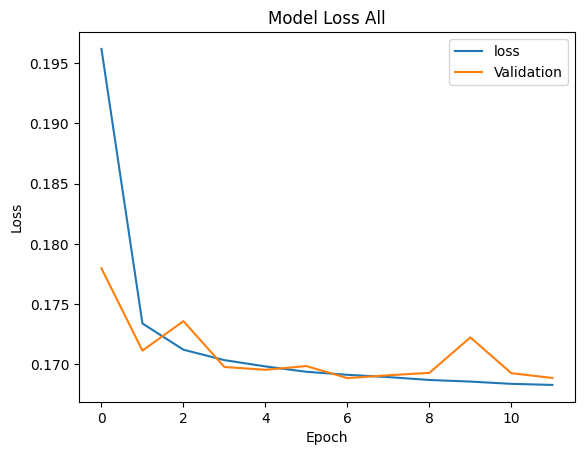

In [23]:
# Plot the training and validation loss
plt.plot(myhistory_all.history['loss'])
plt.plot(myhistory_all.history['val_loss'])
plt.title('Model Loss All')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'Validation'], loc='upper right')
plt.show()

In [129]:
preds_all_BCE = model_all.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
fpr_all_BCE, tpr_all_BCE, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_BCE)

100/100 [==============================] - 0s 690us/step


In [5]:
#model_all_BCE = tf.keras.models.load_model("model_all_ordered_BCE")
#model_all_MSE = tf.keras.models.load_model("model_all_MSE_3_4096")

In [102]:
#preds_all_MSE = model_all_MSE.predict(X_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1],batch_size=1000)
#fpr_all_MSE, tpr_all_MSE, _ = metrics.roc_curve(Y_val_all[np.product(X_val_all[:,4:6]==[1,1],axis=1)==1], preds_all_MSE)

99/99 [==============================] - 0s 2ms/step


In [130]:
preds_100_BCE = model_dedicated.predict(X_val_100,batch_size=1000)
fpr_100_BCE, tpr_100_BCE, _ = metrics.roc_curve(Y_val_100, preds_100_BCE)

99/99 [==============================] - 0s 675us/step


/tmp/ipykernel_808700/2993218434.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_100_BCE,1./(fpr_100_BCE),label="dedicated_100")
/tmp/ipykernel_808700/2993218434.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_all_BCE,1./(fpr_all_BCE),label="parameterized_100")


Text(0.5, 1.0, '$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE (Optimized)')

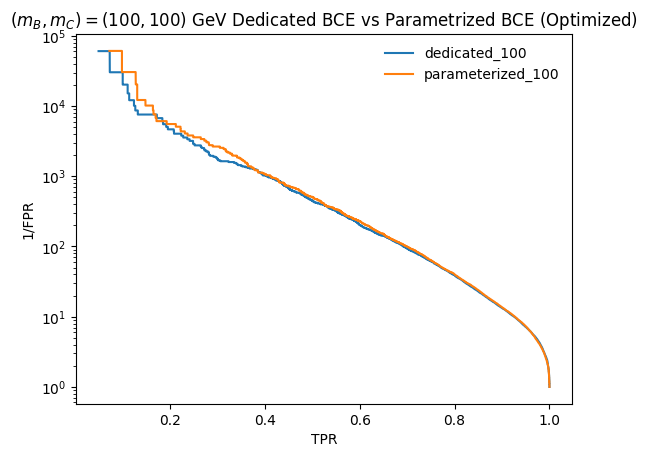

In [131]:
epsilon = 1e-6
plt.plot(tpr_100_BCE,1./(fpr_100_BCE),label="dedicated_100")
plt.plot(tpr_all_BCE,1./(fpr_all_BCE),label="parameterized_100")

plt.yscale("log")
plt.legend(frameon=False)
plt.xlabel("TPR")
plt.ylabel("1/FPR")
plt.title("$(m_B,m_C) = (100,100)$ GeV Dedicated BCE vs Parametrized BCE (Optimized)")

In [82]:
#freezes the layers of the model (i.e all trainable params)
for l in model_all.layers:
    l.trainable=False

model3 = createSimpleModel(2.)
model32 = createSimpleModel(3.)

#create final model with everything combined
inputs = tf.keras.Input(shape=(4,))
concatenated_inputs = tf.keras.layers.concatenate([inputs, model3(tf.ones_like(inputs)[:,0]), model32(tf.ones_like(inputs)[:,0])])
hidden_layer_1 = model_all_BCE(concatenated_inputs)
model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

In [24]:
model_all2.trainable_weights

[<tf.Variable 'dense_8/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[2.]], dtype=float32)>,
 <tf.Variable 'dense_9/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[3.]], dtype=float32)>]

In [83]:
myhistory_all2 = model_all2.fit(x_vals_100[:,0:4], y_vals_100, epochs=10,validation_data=(X_val_100[:,0:4], Y_val_100),batch_size=1024)

Epoch 1/10
193/193 [==============================] - 1s 3ms/step - loss: 3.0335 - val_loss: 2.8581
Epoch 2/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7964 - val_loss: 2.7314
Epoch 3/10
193/193 [==============================] - 0s 2ms/step - loss: 2.7099 - val_loss: 2.6704
Epoch 4/10
193/193 [==============================] - 0s 2ms/step - loss: 2.6482 - val_loss: 2.6068
Epoch 5/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5891 - val_loss: 2.5549
Epoch 6/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5492 - val_loss: 2.5264
Epoch 7/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5264 - val_loss: 2.5062
Epoch 8/10
193/193 [==============================] - 0s 2ms/step - loss: 2.5055 - val_loss: 2.4842
Epoch 9/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4825 - val_loss: 2.4604
Epoch 10/10
193/193 [==============================] - 0s 2ms/step - loss: 2.4584 - val_loss: 2.4398

In [8]:
model_all = tf.keras.models.load_model("model_all_BCE")
#model_all_MSE = tf.keras.models.load_model("model_all_MSE_3_4096")

2023-11-20 14:04:51.753439: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 14:04:52.836565: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37319 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:c3:00.0, compute capability: 8.0


In [32]:
xx = []
mm = []
for m1 in mass_range[1:]:
        for m2 in mass_range[1:]:

            #freeze layers
            for l in model_all.layers:
                l.trainable=False

            #create simple models
            model3 = createSimpleModel(2)
            model32 = createSimpleModel(3)

            #combine everything
            inputs = tf.keras.Input(shape=(4,))
            inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
            hidden_layer_1 = model_all(inputs2)
            model_all2 = Model(inputs = inputs, outputs = hidden_layer_1)
            model_all2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

            x_vals_ = np.concatenate([x[0,0],x[m1,m2]])
            y_vals_ = np.concatenate([np.zeros(len(x[0,0])),np.ones(len(x[m1,m2]))])
            X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5)
            myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=20,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024, verbose = 0)
            print(m1,m2,np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1])
            xx += [[np.array(model_all2.trainable_weights).flatten()[0],np.array(model_all2.trainable_weights).flatten()[1]]]
            mm += [[m1,m2]]

0.5 0.5 0.5491803 9.021994
0.5 1 1.1752597 8.985956
0.5 1.5 1.7168411 9.784072
0.5 2 2.2314804 10.173839
0.5 2.5 2.5977345 2.5790203
0.5 3 3.0950694 3.0946405
0.5 3.5 0.5241808 3.4972951
0.5 4 0.5190985 3.983502
0.5 4.5 0.5346133 4.481165
0.5 5 0.53078973 5.008945
0.5 5.5 0.5400266 5.4809976
0.5 6 0.5520322 5.982666
1 0.5 1.1909544 9.069262
1 1 1.0596074 8.468231
1 1.5 1.6835192 8.926991
1 2 2.199494 9.718389
1 2.5 2.56747 2.5462327
1 3 1.0463839 3.010136
1 3.5 1.0547118 3.5140574
1 4 1.0617639 4.003348
1 4.5 1.0545555 4.5172358
1 5 1.0603002 5.007464
1 5.5 1.0624789 5.5290637
1 6 1.0638912 5.9943805
1.5 0.5 1.7238075 9.792358
1.5 1 1.6863937 8.924274
1.5 1.5 1.5503311 1.512562
1.5 2 1.5417204 2.0125449
1.5 2.5 1.5446966 2.5312426
1.5 3 1.5453459 3.013283
1.5 3.5 1.5218555 3.5464509
1.5 4 1.5523617 4.010661
1.5 4.5 1.5658842 4.5100675
1.5 5 1.5637821 5.013837
1.5 5.5 1.5637577 5.5042734
1.5 6 1.5725037 6.012097
2 0.5 2.24231 10.157302
2 1 2.2035065 9.717022
2 1.5 1.5262563 2.0145059
2 

In [33]:
xx = np.array(xx)
mm = np.array(mm)

found_both = 0.
found_one = 0.
found_none = 0.
for i in range(len(mm)):
    diff1 = abs(mm[i][0]-xx[i][0])
    diff2 = abs(mm[i][1]-xx[i][0])
    diff3 = abs(mm[i][0]-xx[i][1])
    diff4 = abs(mm[i][1]-xx[i][1])
    diffs = [diff1,diff2,diff3,diff4]
    if (diff1 < 0.2 and diff4 < 0.2) or (diff2 < 0.2 and diff3 < 0.2):
        #print(mm[i],xx[i])
        found_both+=1
    elif (min(diffs) < 0.2):
        print(mm[i],xx[i])
        found_one+=1
        pass
    else:
        print(mm[i],xx[i])
        found_none+=1
        pass

print("found both:",found_both/(found_both+found_one+found_none))
print("found one:",found_one/(found_both+found_one+found_none))
print("found none:",found_none/(found_both+found_one+found_none))

[0.5 0.5] [0.5491803 9.021994 ]
[0.5 1. ] [1.1752597 8.985956 ]
[0.5 1.5] [1.7168411 9.784072 ]
[0.5 2. ] [ 2.2314804 10.173839 ]
[0.5 2.5] [2.5977345 2.5790203]
[0.5 3. ] [3.0950694 3.0946405]
[1.  0.5] [1.1909544 9.069262 ]
[1. 1.] [1.0596074 8.468231 ]
[1.  1.5] [1.6835192 8.926991 ]
[1. 2.] [2.199494 9.718389]
[1.  2.5] [2.56747   2.5462327]
[1.5 0.5] [1.7238075 9.792358 ]
[1.5 1. ] [1.6863937 8.924274 ]
[2.  0.5] [ 2.24231  10.157302]
[2. 1.] [2.2035065 9.717022 ]
[2.5 0.5] [2.6047301 2.5865421]
[2.5 1. ] [2.5693932 2.5542233]
[3.  0.5] [3.0988517 3.0894363]
[3.5 0.5] [3.5923848 3.5996833]
[5.5 0.5] [0.22287026 5.527169  ]
[6.  0.5] [0.18784916 6.0023403 ]
found both: 0.8541666666666666
found one: 0.1111111111111111
found none: 0.034722222222222224


In [8]:
m1_list = np.unique(x_vals_all[:, -2])
m2_list = np.unique(x_vals_all[:, -1])

In [38]:
m1_list == np.array(mass_range[1:])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [139]:
sig_list

[0.001,
 0.0012742749857031334,
 0.001623776739188721,
 0.00206913808111479,
 0.0026366508987303583,
 0.003359818286283781,
 0.004281332398719396,
 0.00545559478116852,
 0.0069519279617756054,
 0.008858667904100823,
 0.011288378916846888,
 0.01438449888287663,
 0.018329807108324356,
 0.023357214690901212,
 0.029763514416313176,
 0.0379269019073225,
 0.04832930238571752,
 0.06158482110660261,
 0.07847599703514611,
 0.1]

In [43]:
np.shape(x[0,0])

(121352, 4)

In [ ]:
xx = []
yy = []
zz = []
ww = []

msic1 = []
msic2 = []
epsilon = 1e-6

w1 = round(random.uniform(0.5, 6.0),3)
w2 = round(random.uniform(0.5, 6.0),3)

initial_learning_rate = 0.05 #placeholder till callback

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=30*3, decay_rate=0.9, staircase=True
)

for sigfrac in np.logspace(-3,-1,20):
    print(w1, w2, sigfrac)
    #sigfrac = 0.05
    if (sigfrac > 0.5):
        continue

    for l in model_all.layers:
        l.trainable=False

    inputs_hold = tf.keras.Input(shape=(1,))
    simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
    model3 = Model(inputs = inputs_hold, outputs = simple_model)

    inputs_hold2 = tf.keras.Input(shape=(1,))
    simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
    model32 = Model(inputs = inputs_hold2, outputs = simple_model2)
    
    inputs_hold3 = tf.keras.Input(shape=(1,))
    simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
    model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

    inputs = tf.keras.Input(shape=(4,))
    inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
    hidden_layer_1 = model_all(inputs2)
    LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
    #LLR_xs = 1.+sigfrac*LLR - sigfrac
    LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
    backtoprob = LLR_xs / (1.+LLR_xs)
    model_all2 = Model(inputs = inputs, outputs = backtoprob)
    model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule))

    m1 = 3
    m2 = 4.5

    test_set_back = int(len(x[0,0])*0.5)
    train_set_reference = int(len(x[0,0])*0.25)
    train_set_data = len(x[0,0]) - test_set_back - train_set_reference
    test_set_sig = int(len(x[m1,m2])*0.5)
    sig_frac = sigfrac

    tot = train_set_reference
    x_vals_ = np.concatenate([x[0,0][test_set_back:],x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*tot)]])
    y_vals_ = np.concatenate([np.zeros(train_set_reference),np.ones(train_set_data),np.ones(len(x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*tot)]))])

    print(tot,len(x[0,0])-tot,len(x[m1,m2][0:int(sig_frac*tot)]),len(x[m1,m2][0:int(sig_frac*tot)])/tot)

    X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5, random_state = 42)
    
    myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=50,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
    xx+=[sigfrac]
    yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
    zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
    ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
    scores = model_all2.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
    y = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
    fpr, tpr, _ = metrics.roc_curve(y, scores)    
    
    #Now, let's do weakly supervised learning.
    model_cwola = Sequential()
    model_cwola.add(Dense(128, input_dim=4, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(128, activation='relu'))
    model_cwola.add(Dense(1, activation='sigmoid'))
    model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
    
    scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
    y2 = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
    fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
    plt.plot(tpr,tpr/np.sqrt(fpr))
    plt.plot(tpr2,tpr2/np.sqrt(fpr2))
    
    msic1+=[np.max(tpr/np.sqrt(fpr+0.0001))]
    msic2+=[np.max(tpr2/np.sqrt(fpr2+0.0001))]

5.351 2.508 0.001
30338 91014 30 0.0009888588568791614
Epoch 1/50
30/30 [==============================] - 1s 16ms/step - loss: 0.6974 - val_loss: 0.6955
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6943 - val_loss: 0.6941
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6936 - val_loss: 0.6937
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6934
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6933
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 38 0.0012525545520469378
Epoch 1/50
30/30 [==============================] - 1s 19ms/step - loss: 0.6972 - val_loss: 0.6955
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6940 - val_loss: 0.6941
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6933 - val_loss: 0.6937
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6934
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6930 - val_loss: 0.6933
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6930 - val_loss: 0.6933
Epoch 7/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6929 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6929 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 49 0.0016151361329026304
Epoch 1/50
30/30 [==============================] - 1s 22ms/step - loss: 0.6975 - val_loss: 0.6952
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6944 - val_loss: 0.6939
Epoch 3/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6936 - val_loss: 0.6934
Epoch 4/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6929 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 9ms/step - loss:

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 62 0.002043641637550267
Epoch 1/50
30/30 [==============================] - 1s 21ms/step - loss: 0.6968 - val_loss: 0.6953
Epoch 2/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6942 - val_loss: 0.6938
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6935 - val_loss: 0.6934
Epoch 4/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6929 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 9/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 10/50
30/30 [==============================] - 0s 9ms/step - loss: 0.

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 79 0.002603994989781792
Epoch 1/50
30/30 [==============================] - 1s 22ms/step - loss: 0.6968 - val_loss: 0.6952
Epoch 2/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6940 - val_loss: 0.6937
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 4/50
30/30 [==============================] - 0s 15ms/step - loss: 0.6929 - val_loss: 0.6933
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6929 - val_loss: 0.6931
Epoch 6/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6928 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6928 - val_loss: 0.6930
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6928 - val_loss: 0.6930
Epoch 10/50
30/30 [==============================] - 0s 9ms/step - loss: 0.

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 20ms/step - loss: 0.6969 - val_loss: 0.6948
Epoch 2/50
30/30 [==============================] - 0s 17ms/step - loss: 0.6939 - val_loss: 0.6935
Epoch 3/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6934 - val_loss: 0.6931
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6929
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 7/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 9/50
30/30 [==============================] - 0s 15ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 10/50
30/30 [==============================] - 0s 15ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 11/50
30/30 [====

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 129 0.004252093084580394
Epoch 1/50
30/30 [==============================] - 1s 18ms/step - loss: 0.6969 - val_loss: 0.6954
Epoch 2/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6941 - val_loss: 0.6940
Epoch 3/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6935 - val_loss: 0.6935
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6934 - val_loss: 0.6935
Epoch 5/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6932 - val_loss: 0.6935
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6934
Epoch 7/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6934
Epoch 8/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6935
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6934
Epoch 10/50
30/30 [==============================] - 0s 12ms/step - loss: 

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 2s 17ms/step - loss: 0.6963 - val_loss: 0.6944
Epoch 2/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6934 - val_loss: 0.6933
Epoch 3/50
30/30 [==============================] - 0s 15ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6926 - val_loss: 0.6927
Epoch 6/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6926 - val_loss: 0.6927
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6925 - val_loss: 0.6927
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6925 - val_loss: 0.6926
Epoch 9/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6925 - val_loss: 0.6926
Epoch 10/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6925 - val_loss: 0.6926
Epoch 11/50
30/30 [====

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 19ms/step - loss: 0.6961 - val_loss: 0.6945
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6928 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 1s 20ms/step - loss: 0.6922 - val_loss: 0.6927
Epoch 4/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6920 - val_loss: 0.6926
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6920 - val_loss: 0.6926
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6920 - val_loss: 0.6925
Epoch 7/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6920 - val_loss: 0.6925
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6920 - val_loss: 0.6925
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6920 - val_loss: 0.6925
Epoch 10/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6920 - val_loss: 0.6925
Epoch 11/50
30/30 [=====

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 268 0.008833805788120508
Epoch 1/50
30/30 [==============================] - 1s 15ms/step - loss: 0.6958 - val_loss: 0.6935
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6924 - val_loss: 0.6924
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6919 - val_loss: 0.6922
Epoch 4/50
30/30 [==============================] - 1s 24ms/step - loss: 0.6918 - val_loss: 0.6921
Epoch 5/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6917 - val_loss: 0.6920
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6918 - val_loss: 0.6921
Epoch 7/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6917 - val_loss: 0.6920
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6917 - val_loss: 0.6920
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6917 - val_loss: 0.6921
Epoch 10/50
30/30 [==============================] - 0s 11ms/step - loss: 

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


5.351 2.508 0.011288378916846888
30338 91014 342 0.011272990968422441
Epoch 1/50
30/30 [==============================] - 1s 20ms/step - loss: 0.6950 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6921 - val_loss: 0.6918
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6917 - val_loss: 0.6915
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6916 - val_loss: 0.6914
Epoch 5/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6916 - val_loss: 0.6914
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6916 - val_loss: 0.6914
Epoch 7/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6916 - val_loss: 0.6914
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6916 - val_loss: 0.6914
Epoch 9/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6917 - val_loss: 0.6914
Epoch 10/50
30/30 [=========================

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 436 0.014371415386643813
Epoch 1/50
30/30 [==============================] - 1s 18ms/step - loss: 0.6946 - val_loss: 0.6926
Epoch 2/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6911 - val_loss: 0.6916
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6908 - val_loss: 0.6914
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6907 - val_loss: 0.6912
Epoch 5/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6907 - val_loss: 0.6913
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6907 - val_loss: 0.6912
Epoch 7/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6907 - val_loss: 0.6912
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6907 - val_loss: 0.6912
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6907 - val_loss: 0.6913
Epoch 10/50
30/30 [==============================] - 0s 11ms/step - loss: 

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 556 0.01832685081416046
Epoch 1/50
30/30 [==============================] - 2s 24ms/step - loss: 0.6931 - val_loss: 0.6914
Epoch 2/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6905 - val_loss: 0.6905
Epoch 3/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6902 - val_loss: 0.6903
Epoch 4/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6901 - val_loss: 0.6904
Epoch 5/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6901 - val_loss: 0.6903
Epoch 6/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6901 - val_loss: 0.6903
Epoch 7/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6901 - val_loss: 0.6904
Epoch 8/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6903 - val_loss: 0.6903
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6901 - val_loss: 0.6903
Epoch 10/50
30/30 [==============================] - 0s 12ms/step - loss: 0.

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 708 0.02333706902234821
Epoch 1/50
30/30 [==============================] - 1s 21ms/step - loss: 0.6932 - val_loss: 0.6905
Epoch 2/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6898 - val_loss: 0.6895
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6892 - val_loss: 0.6894
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6893 - val_loss: 0.6893
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6891 - val_loss: 0.6894
Epoch 6/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6892 - val_loss: 0.6893
Epoch 7/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6891 - val_loss: 0.6894
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6893 - val_loss: 0.6893
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6892 - val_loss: 0.6894
Epoch 10/50
30/30 [==============================] - 0s 11ms/step - loss: 0

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 902 0.02973168963016679
Epoch 1/50
31/31 [==============================] - 1s 22ms/step - loss: 0.6901 - val_loss: 0.6887
Epoch 2/50
31/31 [==============================] - 0s 14ms/step - loss: 0.6882 - val_loss: 0.6880
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6880 - val_loss: 0.6880
Epoch 4/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6880 - val_loss: 0.6881
Epoch 5/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6880 - val_loss: 0.6881
Epoch 6/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6879 - val_loss: 0.6880
Epoch 7/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6879 - val_loss: 0.6881
Epoch 8/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6880 - val_loss: 0.6880
Epoch 9/50
31/31 [==============================] - 0s 14ms/step - loss: 0.6880 - val_loss: 0.6882
Epoch 10/50
31/31 [==============================] - 0s 11ms/step - loss: 

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 1150 0.03790625618036786
Epoch 1/50
31/31 [==============================] - 1s 19ms/step - loss: 0.6896 - val_loss: 0.6871
Epoch 2/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6863 - val_loss: 0.6866
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6861 - val_loss: 0.6865
Epoch 4/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6862 - val_loss: 0.6865
Epoch 5/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6861 - val_loss: 0.6865
Epoch 6/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6862 - val_loss: 0.6865
Epoch 7/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6863 - val_loss: 0.6865
Epoch 8/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6861 - val_loss: 0.6865
Epoch 9/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6862 - val_loss: 0.6865
Epoch 10/50
31/31 [==============================] - 0s 8ms/step - loss: 0.

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 14ms/step - loss: 0.6866 - val_loss: 0.6844
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6840 - val_loss: 0.6843
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6839 - val_loss: 0.6842
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6838 - val_loss: 0.6842
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6838 - val_loss: 0.6842
Epoch 6/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6839 - val_loss: 0.6843
Epoch 7/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6838 - val_loss: 0.6843
Epoch 8/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6839 - val_loss: 0.6842
Epoch 9/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6839 - val_loss: 0.6843
Epoch 10/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6839 - val_loss: 0.6843
Epoch 11/50
31/31 [======

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 14ms/step - loss: 0.6832 - val_loss: 0.6814
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6808 - val_loss: 0.6813
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6808 - val_loss: 0.6813
Epoch 4/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6808 - val_loss: 0.6814
Epoch 5/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6808 - val_loss: 0.6814
Epoch 6/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6810 - val_loss: 0.6814
Epoch 7/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6807 - val_loss: 0.6813
Epoch 8/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6807 - val_loss: 0.6814
Epoch 9/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6808 - val_loss: 0.6814
Epoch 10/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6807 - val_loss: 0.6814
Epoch 11/50
31/31 [===

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 22ms/step - loss: 0.6796 - val_loss: 0.6773
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6771 - val_loss: 0.6770
Epoch 3/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6771 - val_loss: 0.6771
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6771 - val_loss: 0.6775
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6772 - val_loss: 0.6773
Epoch 6/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6772 - val_loss: 0.6771
Epoch 7/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6772 - val_loss: 0.6770
Epoch 8/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6772 - val_loss: 0.6772
Epoch 9/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6773 - val_loss: 0.6771
Epoch 10/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6772 - val_loss: 0.6770
Epoch 11/50
31/31 [=====

/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:89: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/758399123.py:90: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 3033 0.09997363043048323
Epoch 1/50
32/32 [==============================] - 1s 16ms/step - loss: 0.6742 - val_loss: 0.6731
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.6716 - val_loss: 0.6732
Epoch 3/50
32/32 [==============================] - 0s 11ms/step - loss: 0.6717 - val_loss: 0.6731
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.6716 - val_loss: 0.6733
Epoch 5/50
32/32 [==============================] - 0s 10ms/step - loss: 0.6721 - val_loss: 0.6733
Epoch 6/50
32/32 [==============================] - 0s 11ms/step - loss: 0.6717 - val_loss: 0.6731
Epoch 7/50
32/32 [==============================] - 0s 11ms/step - loss: 0.6717 - val_loss: 0.6731
Epoch 8/50
22/32 [===================>..........] - ETA: 0s - loss: 0.6713

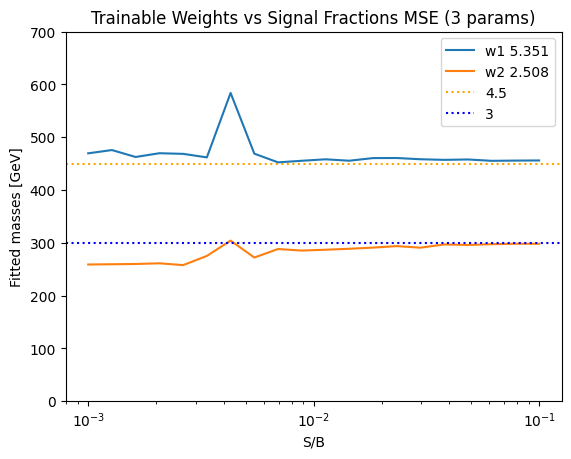

In [17]:
plt.plot(xx,np.array(yy)*100, label = f"w1 {w1}")
plt.plot(xx,np.array(zz)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (3 params)")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])
plt.show()

Text(0, 0.5, 'Max SIC')

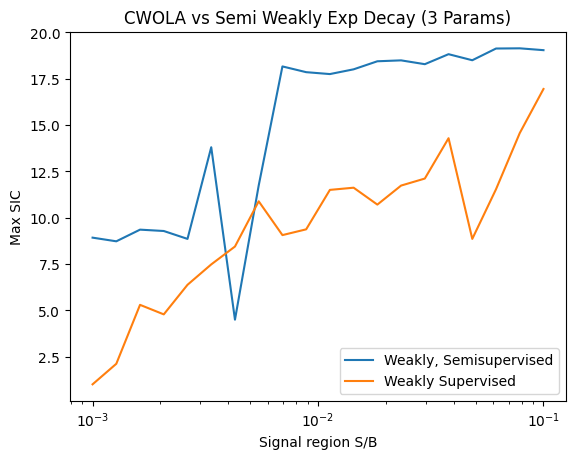

In [18]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly Exp Decay (3 Params)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Max SIC")

Text(0, 0.5, 'Fitted S/B')

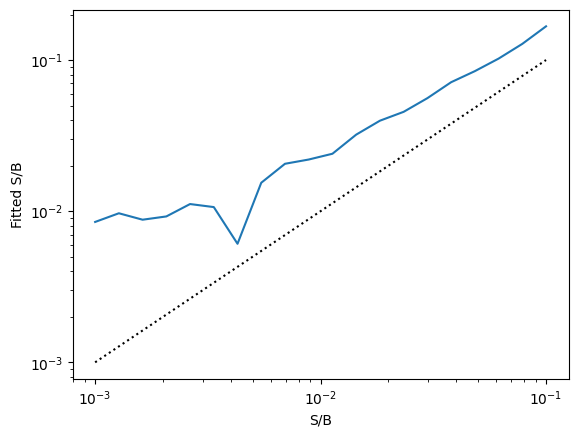

In [19]:
plt.plot(xx,np.array(ww))
plt.xscale("log")
plt.yscale("log")
plt.plot(xx,xx,ls=":",color="black")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")

Text(0, 0.5, 'Max SIC')

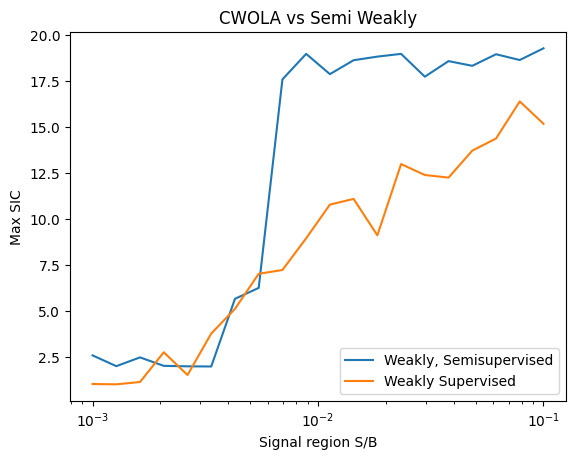

In [11]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Max SIC")

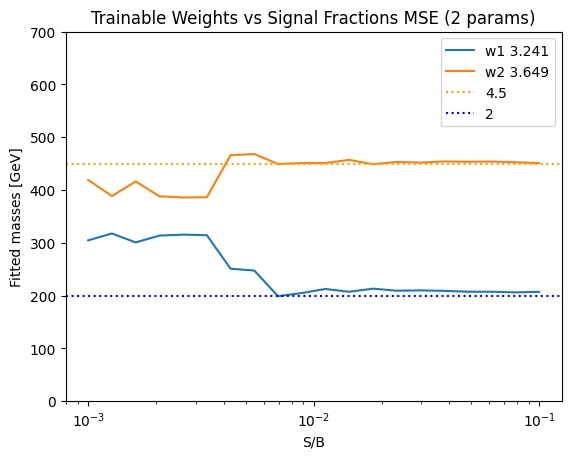

In [21]:
plt.plot(xx,np.array(yy)*100, label = f"w1 {w1}")
plt.plot(xx,np.array(zz)*100, label = f"w2 {w2}")
plt.xscale("log")
plt.xlabel("S/B")
plt.ylabel("Fitted masses [GeV]")
plt.title("Trainable Weights vs Signal Fractions MSE (2 params)")
plt.axhline(m2 * 100,ls=":",color='orange', label = m2)
plt.axhline(m1 * 100,ls=":",color='blue', label = m1)
plt.legend()
plt.ylim([0,700])
plt.show()

Text(0, 0.5, 'max SIC')

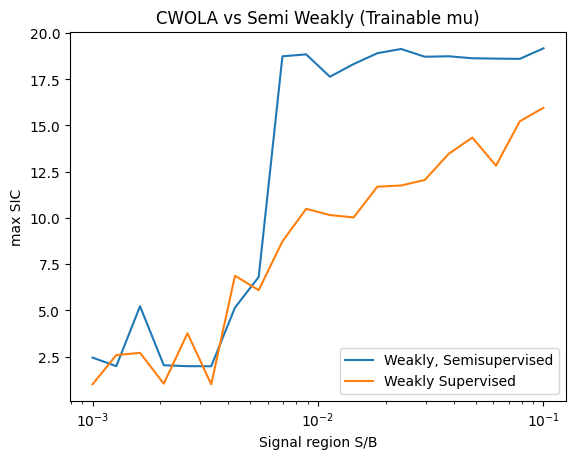

In [18]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

Text(0, 0.5, 'Fitted S/B')

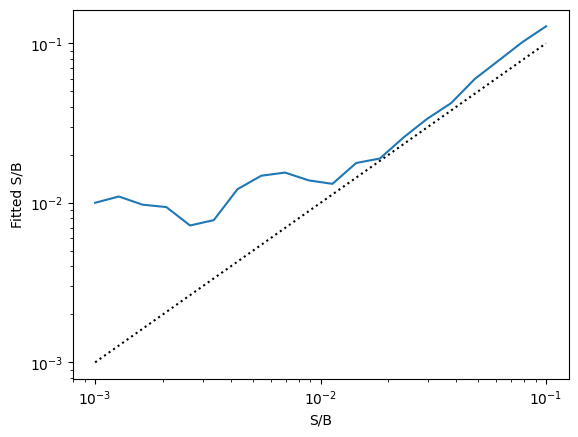

In [15]:
plt.plot(xx,np.array(ww))
plt.xscale("log")
plt.yscale("log")
plt.plot(xx,xx,ls=":",color="black")
plt.xlabel("S/B")
plt.ylabel("Fitted S/B")

Text(0, 0.5, 'max SIC')

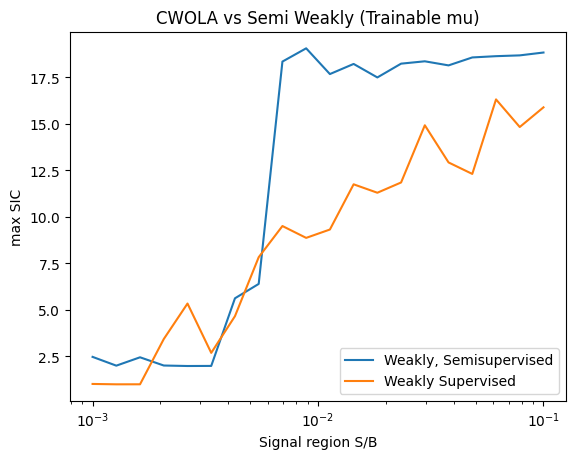

In [22]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

Text(0, 0.5, 'max SIC')

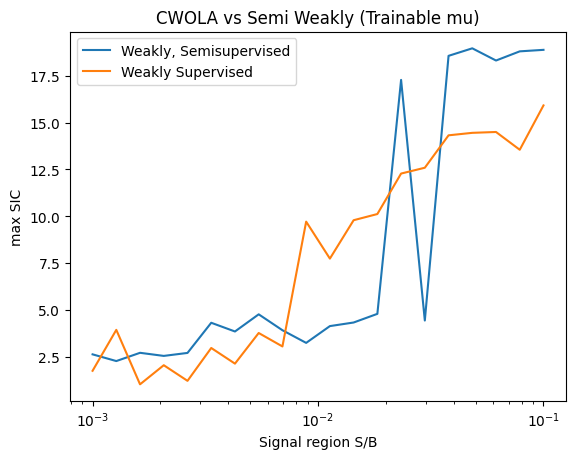

In [56]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

Text(0, 0.5, 'max SIC')

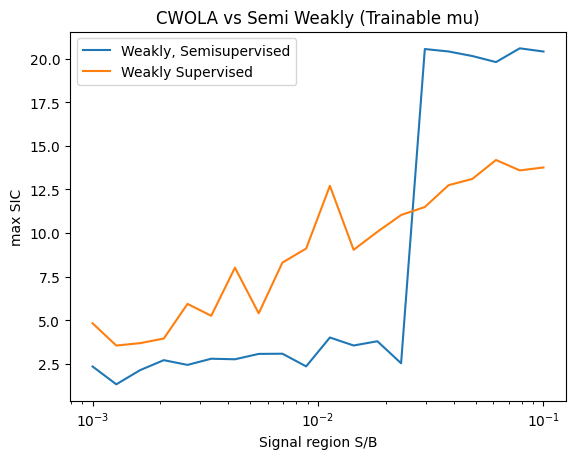

In [115]:
plt.plot(xx,msic1,label="Weakly, Semisupervised")
plt.plot(xx,msic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (Trainable mu)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("max SIC")

4.562 4.338 0.001
30338 91014 30 0.0009888588568791614
Epoch 1/50
30/30 [==============================] - 1s 18ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 15ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 11/50
30/30 [====

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 49 0.0016151361329026304
Epoch 1/50
30/30 [==============================] - 1s 16ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 14ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 14ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 15ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 11/50
30/30 [=====

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 79 0.002603994989781792
Epoch 1/50
30/30 [==============================] - 1s 20ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 15ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 9ms/step - loss: 0.

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 16ms/step - loss: 0.6933 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 11/50
30/30 [======

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 129 0.004252093084580394
Epoch 1/50
30/30 [==============================] - 1s 18ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 0.

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 15ms/step - loss: 0.6933 - val_loss: 0.6930
Epoch 2/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6933 - val_loss: 0.6930
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 11/50
30/30 [====

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 16ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 6/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6923 - val_loss: 0.6925
Epoch 7/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6922 - val_loss: 0.6925
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6922 - val_loss: 0.6924
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6922 - val_loss: 0.6924
Epoch 10/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6922 - val_loss: 0.6924
Epoch 11/50
30/30 [====

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 268 0.008833805788120508
Epoch 1/50
30/30 [==============================] - 1s 20ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6926 - val_loss: 0.6923
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6920 - val_loss: 0.6921
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6919 - val_loss: 0.6920
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6919 - val_loss: 0.6920
Epoch 7/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6919 - val_loss: 0.6920
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6919 - val_loss: 0.6921
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6919 - val_loss: 0.6920
Epoch 10/50
30/30 [==============================] - 0s 8ms/step - loss: 0.

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 342 0.011272990968422441
Epoch 1/50
30/30 [==============================] - 1s 20ms/step - loss: 0.6932 - val_loss: 0.6930
Epoch 2/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6930
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 11ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 17ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 6/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6929 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6929 - val_loss: 0.6931
Epoch 11/50
30/30 [======

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 16ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 3/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 5/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6929 - val_loss: 0.6927
Epoch 10/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6928 - val_loss: 0.6926
Epoch 11/50
30/30 [=====

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 708 0.02333706902234821
Epoch 1/50
30/30 [==============================] - 1s 21ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6927 - val_loss: 0.6926
Epoch 5/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6907 - val_loss: 0.6900
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6894 - val_loss: 0.6896
Epoch 7/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6893 - val_loss: 0.6896
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6893 - val_loss: 0.6897
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6895 - val_loss: 0.6896
Epoch 10/50
30/30 [==============================] - 0s 11ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 902 0.02973168963016679
Epoch 1/50
31/31 [==============================] - 1s 18ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 2/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6925 - val_loss: 0.6924
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6916 - val_loss: 0.6885
Epoch 5/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6882 - val_loss: 0.6884
Epoch 6/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6882 - val_loss: 0.6883
Epoch 7/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6883 - val_loss: 0.6883
Epoch 8/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6881 - val_loss: 0.6890
Epoch 9/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6885 - val_loss: 0.6883
Epoch 10/50
31/31 [==============================] - 0s 12ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 1150 0.03790625618036786
Epoch 1/50
31/31 [==============================] - 1s 12ms/step - loss: 0.6922 - val_loss: 0.6918
Epoch 2/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6908 - val_loss: 0.6879
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6869 - val_loss: 0.6870
Epoch 4/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6865 - val_loss: 0.6869
Epoch 5/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6865 - val_loss: 0.6870
Epoch 6/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6865 - val_loss: 0.6869
Epoch 7/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6865 - val_loss: 0.6873
Epoch 8/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6866 - val_loss: 0.6870
Epoch 9/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6865 - val_loss: 0.6870
Epoch 10/50
31/31 [==============================] - 0s 9ms/step - loss: 0.

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 1466 0.048322236139495024
Epoch 1/50
31/31 [==============================] - 1s 18ms/step - loss: 0.6918 - val_loss: 0.6913
Epoch 2/50
31/31 [==============================] - 0s 7ms/step - loss: 0.6917 - val_loss: 0.6913
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6917 - val_loss: 0.6913
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6918 - val_loss: 0.6913
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6918 - val_loss: 0.6913
Epoch 6/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6918 - val_loss: 0.6913
Epoch 7/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6912 - val_loss: 0.6892
Epoch 8/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6852 - val_loss: 0.6849
Epoch 9/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6844 - val_loss: 0.6850
Epoch 10/50
31/31 [==============================] - 0s 8ms/step - loss: 0.

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 1868 0.06157294482167579
Epoch 1/50
31/31 [==============================] - 2s 31ms/step - loss: 0.6905 - val_loss: 0.6903
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6852 - val_loss: 0.6827
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6813 - val_loss: 0.6824
Epoch 4/50
31/31 [==============================] - 0s 16ms/step - loss: 0.6813 - val_loss: 0.6824
Epoch 5/50
31/31 [==============================] - 0s 15ms/step - loss: 0.6813 - val_loss: 0.6823
Epoch 6/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6812 - val_loss: 0.6822
Epoch 7/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6813 - val_loss: 0.6822
Epoch 8/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6814 - val_loss: 0.6827
Epoch 9/50
31/31 [==============================] - 0s 14ms/step - loss: 0.6812 - val_loss: 0.6825
Epoch 10/50
31/31 [==============================] - 0s 10ms/step - loss: 

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 2380 0.07844946931241348
Epoch 1/50
31/31 [==============================] - 1s 16ms/step - loss: 0.6883 - val_loss: 0.6818
Epoch 2/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6789 - val_loss: 0.6787
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6783 - val_loss: 0.6785
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6783 - val_loss: 0.6784
Epoch 5/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6781 - val_loss: 0.6783
Epoch 6/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6782 - val_loss: 0.6783
Epoch 7/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6782 - val_loss: 0.6783
Epoch 8/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6781 - val_loss: 0.6783
Epoch 9/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6781 - val_loss: 0.6785
Epoch 10/50
31/31 [==============================] - 0s 10ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


Epoch 1/50
32/32 [==============================] - 1s 17ms/step - loss: 0.6843 - val_loss: 0.6753
Epoch 2/50
32/32 [==============================] - 0s 11ms/step - loss: 0.6738 - val_loss: 0.6756
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.6733 - val_loss: 0.6749
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.6731 - val_loss: 0.6751
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.6731 - val_loss: 0.6751
Epoch 6/50
32/32 [==============================] - 0s 8ms/step - loss: 0.6731 - val_loss: 0.6750
Epoch 7/50
32/32 [==============================] - 0s 10ms/step - loss: 0.6730 - val_loss: 0.6750
Epoch 8/50
32/32 [==============================] - 0s 8ms/step - loss: 0.6731 - val_loss: 0.6750
Epoch 9/50
32/32 [==============================] - 0s 11ms/step - loss: 0.6731 - val_loss: 0.6749
Epoch 10/50
32/32 [==============================] - 0s 11ms/step - loss: 0.6730 - val_loss: 0.6749
Epoch 11/50
3

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 30 0.0009888588568791614
Epoch 1/50
30/30 [==============================] - 1s 19ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 9ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 38 0.0012525545520469378
Epoch 1/50
30/30 [==============================] - 1s 19ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 8ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 49 0.0016151361329026304
Epoch 1/50
30/30 [==============================] - 2s 22ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 62 0.002043641637550267
Epoch 1/50
30/30 [==============================] - 1s 14ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 3/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 15ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 13ms/step - loss: 

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 79 0.002603994989781792
Epoch 1/50
30/30 [==============================] - 1s 19ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 3/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 9/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 10/50
30/30 [==============================] - 0s 12ms/step - loss: 0.

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 101 0.003329158151493177
Epoch 1/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 2/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 5/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 9ms/step - loss: 0.

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 129 0.004252093084580394
Epoch 1/50
30/30 [==============================] - 1s 23ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 20ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 2/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6933 - val_loss: 0.6934
Epoch 3/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6933 - val_loss: 0.6934
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6933 - val_loss: 0.6934
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6933 - val_loss: 0.6934
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6934
Epoch 7/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6932 - val_loss: 0.6934
Epoch 8/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6932 - val_loss: 0.6934
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6934
Epoch 10/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6934
Epoch 11/50
30/30 [======

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 210 0.00692201199815413
Epoch 1/50
30/30 [==============================] - 2s 22ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6934
Epoch 6/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6933 - val_loss: 0.6936
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6933 - val_loss: 0.6936
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6933 - val_loss: 0.6935
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6933 - val_loss: 0.6935
Epoch 10/50
30/30 [==============================] - 0s 12ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 268 0.008833805788120508
Epoch 1/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6934 - val_loss: 0.6936
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6935
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6933 - val_loss: 0.6936
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6936
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6933 - val_loss: 0.6937
Epoch 6/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6933 - val_loss: 0.6936
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6933 - val_loss: 0.6936
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6933 - val_loss: 0.6936
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6936
Epoch 10/50
30/30 [==============================] - 0s 9ms/step - loss: 0.

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 342 0.011272990968422441
Epoch 1/50
30/30 [==============================] - 1s 14ms/step - loss: 0.6935 - val_loss: 0.6936
Epoch 2/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6934 - val_loss: 0.6936
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6934 - val_loss: 0.6936
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6934 - val_loss: 0.6936
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6934 - val_loss: 0.6936
Epoch 6/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6934 - val_loss: 0.6936
Epoch 7/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6934 - val_loss: 0.6936
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6934 - val_loss: 0.6936
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6934 - val_loss: 0.6936
Epoch 10/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 17ms/step - loss: 0.6935 - val_loss: 0.6937
Epoch 2/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6933 - val_loss: 0.6935
Epoch 3/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6934
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6935
Epoch 8/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 9/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 11/50
30/30 [=====

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 15ms/step - loss: 0.6937 - val_loss: 0.6937
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6936 - val_loss: 0.6938
Epoch 3/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6937 - val_loss: 0.6937
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6936 - val_loss: 0.6935
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6936 - val_loss: 0.6934
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6935 - val_loss: 0.6935
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6935 - val_loss: 0.6934
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6935 - val_loss: 0.6935
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6935 - val_loss: 0.6933
Epoch 10/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6935 - val_loss: 0.6930
Epoch 11/50
30/30 [=====

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 708 0.02333706902234821
Epoch 1/50
30/30 [==============================] - 3s 83ms/step - loss: 0.6938 - val_loss: 0.6937
Epoch 2/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6936 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 15ms/step - loss: 0.6934 - val_loss: 0.6928
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6920 - val_loss: 0.6900
Epoch 5/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6895 - val_loss: 0.6896
Epoch 6/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6894 - val_loss: 0.6896
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6894 - val_loss: 0.6896
Epoch 8/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6893 - val_loss: 0.6896
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6894 - val_loss: 0.6896
Epoch 10/50
30/30 [==============================] - 0s 11ms/step - loss: 

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 902 0.02973168963016679
Epoch 1/50
31/31 [==============================] - 1s 19ms/step - loss: 0.6938 - val_loss: 0.6936
Epoch 2/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6934 - val_loss: 0.6933
Epoch 3/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6934 - val_loss: 0.6931
Epoch 4/50
31/31 [==============================] - 0s 14ms/step - loss: 0.6926 - val_loss: 0.6919
Epoch 5/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6892 - val_loss: 0.6885
Epoch 6/50
31/31 [==============================] - 0s 16ms/step - loss: 0.6885 - val_loss: 0.6883
Epoch 7/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6883 - val_loss: 0.6883
Epoch 8/50
31/31 [==============================] - 0s 14ms/step - loss: 0.6882 - val_loss: 0.6883
Epoch 9/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6883 - val_loss: 0.6886
Epoch 10/50
31/31 [==============================] - 0s 9ms/step - loss: 

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 1150 0.03790625618036786
Epoch 1/50
31/31 [==============================] - 1s 18ms/step - loss: 0.6943 - val_loss: 0.6945
Epoch 2/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6942 - val_loss: 0.6944
Epoch 3/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6941 - val_loss: 0.6944
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6941 - val_loss: 0.6943
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6941 - val_loss: 0.6937
Epoch 6/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6940 - val_loss: 0.6937
Epoch 7/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6938 - val_loss: 0.6930
Epoch 8/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6927 - val_loss: 0.6911
Epoch 9/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6881 - val_loss: 0.6875
Epoch 10/50
31/31 [==============================] - 0s 9ms/step - loss: 0.68

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 1466 0.048322236139495024
Epoch 1/50
31/31 [==============================] - 1s 19ms/step - loss: 0.6948 - val_loss: 0.6950
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6943 - val_loss: 0.6943
Epoch 3/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6938 - val_loss: 0.6940
Epoch 4/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6935 - val_loss: 0.6940
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6935 - val_loss: 0.6940
Epoch 6/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6936 - val_loss: 0.6940
Epoch 7/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6935 - val_loss: 0.6940
Epoch 8/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6935 - val_loss: 0.6940
Epoch 9/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6935 - val_loss: 0.6940
Epoch 10/50
31/31 [==============================] - 0s 11ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 1868 0.06157294482167579
Epoch 1/50
31/31 [==============================] - 1s 17ms/step - loss: 0.6935 - val_loss: 0.6920
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6872 - val_loss: 0.6823
Epoch 3/50
31/31 [==============================] - 1s 20ms/step - loss: 0.6813 - val_loss: 0.6822
Epoch 4/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6813 - val_loss: 0.6822
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6813 - val_loss: 0.6827
Epoch 6/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6815 - val_loss: 0.6825
Epoch 7/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6813 - val_loss: 0.6823
Epoch 8/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6812 - val_loss: 0.6824
Epoch 9/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6813 - val_loss: 0.6822
Epoch 10/50
31/31 [==============================] - 0s 9ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 2380 0.07844946931241348
Epoch 1/50
31/31 [==============================] - 1s 15ms/step - loss: 0.6904 - val_loss: 0.6838
Epoch 2/50
31/31 [==============================] - 1s 17ms/step - loss: 0.6794 - val_loss: 0.6785
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6782 - val_loss: 0.6785
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6781 - val_loss: 0.6783
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6782 - val_loss: 0.6784
Epoch 6/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6780 - val_loss: 0.6783
Epoch 7/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6780 - val_loss: 0.6783
Epoch 8/50
31/31 [==============================] - 0s 7ms/step - loss: 0.6781 - val_loss: 0.6783
Epoch 9/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6781 - val_loss: 0.6784
Epoch 10/50
31/31 [==============================] - 0s 9ms/step - loss: 0.

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


Epoch 1/50
32/32 [==============================] - 1s 17ms/step - loss: 0.6922 - val_loss: 0.6853
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.6764 - val_loss: 0.6750
Epoch 3/50
32/32 [==============================] - 0s 13ms/step - loss: 0.6731 - val_loss: 0.6752
Epoch 4/50
32/32 [==============================] - 0s 11ms/step - loss: 0.6732 - val_loss: 0.6753
Epoch 5/50
32/32 [==============================] - 0s 11ms/step - loss: 0.6732 - val_loss: 0.6751
Epoch 6/50
32/32 [==============================] - 0s 8ms/step - loss: 0.6732 - val_loss: 0.6751
Epoch 7/50
32/32 [==============================] - 0s 13ms/step - loss: 0.6731 - val_loss: 0.6750
Epoch 8/50
32/32 [==============================] - 0s 8ms/step - loss: 0.6731 - val_loss: 0.6752
Epoch 9/50
32/32 [==============================] - 0s 9ms/step - loss: 0.6732 - val_loss: 0.6749
Epoch 10/50
32/32 [==============================] - 0s 9ms/step - loss: 0.6730 - val_loss: 0.6750
Epoch 11/50
32

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 30 0.0009888588568791614
Epoch 1/50
30/30 [==============================] - 1s 16ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 5/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 23ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 5/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 11/50
30/30 [====

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


Epoch 1/50
30/30 [==============================] - 1s 20ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 11/50
30

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 15ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 11/50
30/30 [===

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 79 0.002603994989781792
Epoch 1/50
30/30 [==============================] - 1s 19ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 0.

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 101 0.003329158151493177
Epoch 1/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6933 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 12ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 129 0.004252093084580394
Epoch 1/50
30/30 [==============================] - 2s 22ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 11ms/step - loss: 0.

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 165 0.005438723712835388
Epoch 1/50
30/30 [==============================] - 1s 19ms/step - loss: 0.6933 - val_loss: 0.6930
Epoch 2/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6933 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 5/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 6/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 14ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6927
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6922 - val_loss: 0.6925
Epoch 4/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6922 - val_loss: 0.6924
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6921 - val_loss: 0.6925
Epoch 6/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6921 - val_loss: 0.6925
Epoch 7/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6922 - val_loss: 0.6926
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6922 - val_loss: 0.6924
Epoch 9/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6922 - val_loss: 0.6926
Epoch 10/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6922 - val_loss: 0.6924
Epoch 11/50
30/30 [====

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 2s 29ms/step - loss: 0.6932 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 15ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6920 - val_loss: 0.6920
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6919 - val_loss: 0.6920
Epoch 6/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6919 - val_loss: 0.6920
Epoch 7/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6919 - val_loss: 0.6920
Epoch 8/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6918 - val_loss: 0.6921
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6919 - val_loss: 0.6921
Epoch 10/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6918 - val_loss: 0.6920
Epoch 11/50
30/30 [=

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 342 0.011272990968422441
Epoch 1/50
30/30 [==============================] - 1s 21ms/step - loss: 0.6932 - val_loss: 0.6930
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6924 - val_loss: 0.6915
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6918 - val_loss: 0.6916
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6917 - val_loss: 0.6916
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6917 - val_loss: 0.6915
Epoch 7/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6917 - val_loss: 0.6916
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6917 - val_loss: 0.6915
Epoch 9/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6917 - val_loss: 0.6915
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 436 0.014371415386643813
Epoch 1/50
30/30 [==============================] - 1s 16ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6929 - val_loss: 0.6927
Epoch 3/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6915 - val_loss: 0.6914
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6909 - val_loss: 0.6915
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6909 - val_loss: 0.6913
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6909 - val_loss: 0.6913
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6909 - val_loss: 0.6913
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6909 - val_loss: 0.6915
Epoch 9/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6909 - val_loss: 0.6914
Epoch 10/50
30/30 [==============================] - 0s 12ms/step - loss: 

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 556 0.01832685081416046
Epoch 1/50
30/30 [==============================] - 1s 19ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6918 - val_loss: 0.6909
Epoch 5/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6904 - val_loss: 0.6904
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6903 - val_loss: 0.6903
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6903 - val_loss: 0.6905
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6903 - val_loss: 0.6905
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6903 - val_loss: 0.6904
Epoch 10/50
30/30 [==============================] - 0s 12ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 708 0.02333706902234821
Epoch 1/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6927 - val_loss: 0.6920
Epoch 2/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6904 - val_loss: 0.6901
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6894 - val_loss: 0.6897
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6894 - val_loss: 0.6895
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6894 - val_loss: 0.6897
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6894 - val_loss: 0.6897
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6894 - val_loss: 0.6897
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6894 - val_loss: 0.6895
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6893 - val_loss: 0.6897
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 16ms/step - loss: 0.6927 - val_loss: 0.6925
Epoch 2/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6924 - val_loss: 0.6925
Epoch 3/50
31/31 [==============================] - 0s 7ms/step - loss: 0.6925 - val_loss: 0.6925
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6919 - val_loss: 0.6896
Epoch 5/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6883 - val_loss: 0.6885
Epoch 6/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6881 - val_loss: 0.6886
Epoch 7/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6881 - val_loss: 0.6891
Epoch 8/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6885 - val_loss: 0.6883
Epoch 9/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6882 - val_loss: 0.6886
Epoch 10/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6883 - val_loss: 0.6883
Epoch 11/50
31/31 [====

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


Epoch 1/50
31/31 [==============================] - 1s 18ms/step - loss: 0.6922 - val_loss: 0.6920
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6921 - val_loss: 0.6920
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6921 - val_loss: 0.6920
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6920 - val_loss: 0.6917
Epoch 5/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6910 - val_loss: 0.6879
Epoch 6/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6869 - val_loss: 0.6872
Epoch 7/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6865 - val_loss: 0.6869
Epoch 8/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6864 - val_loss: 0.6870
Epoch 9/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6865 - val_loss: 0.6870
Epoch 10/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6864 - val_loss: 0.6870
Epoch 11/50

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 1466 0.048322236139495024
Epoch 1/50
31/31 [==============================] - 1s 22ms/step - loss: 0.6900 - val_loss: 0.6855
Epoch 2/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6842 - val_loss: 0.6848
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6843 - val_loss: 0.6849
Epoch 4/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6841 - val_loss: 0.6851
Epoch 5/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6845 - val_loss: 0.6852
Epoch 6/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6843 - val_loss: 0.6849
Epoch 7/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6842 - val_loss: 0.6848
Epoch 8/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6842 - val_loss: 0.6848
Epoch 9/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6842 - val_loss: 0.6850
Epoch 10/50
31/31 [==============================] - 0s 9ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 1868 0.06157294482167579
Epoch 1/50
31/31 [==============================] - 1s 19ms/step - loss: 0.6878 - val_loss: 0.6822
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6817 - val_loss: 0.6826
Epoch 3/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6813 - val_loss: 0.6824
Epoch 4/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6814 - val_loss: 0.6822
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6812 - val_loss: 0.6822
Epoch 6/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6813 - val_loss: 0.6822
Epoch 7/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6812 - val_loss: 0.6825
Epoch 8/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6812 - val_loss: 0.6822
Epoch 9/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6813 - val_loss: 0.6823
Epoch 10/50
31/31 [==============================] - 0s 9ms/step - loss: 0.

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 20ms/step - loss: 0.6834 - val_loss: 0.6794
Epoch 2/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6782 - val_loss: 0.6783
Epoch 3/50
31/31 [==============================] - 1s 24ms/step - loss: 0.6780 - val_loss: 0.6783
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6780 - val_loss: 0.6783
Epoch 5/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6781 - val_loss: 0.6784
Epoch 6/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6781 - val_loss: 0.6783
Epoch 7/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6781 - val_loss: 0.6784
Epoch 8/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6782 - val_loss: 0.6784
Epoch 9/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6781 - val_loss: 0.6783
Epoch 10/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6782 - val_loss: 0.6785
Epoch 11/50
31/31 [==

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 3033 0.09997363043048323
Epoch 1/50
32/32 [==============================] - 1s 18ms/step - loss: 0.6800 - val_loss: 0.6757
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.6735 - val_loss: 0.6749
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.6732 - val_loss: 0.6750
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.6732 - val_loss: 0.6750
Epoch 5/50
32/32 [==============================] - 0s 11ms/step - loss: 0.6732 - val_loss: 0.6750
Epoch 6/50
32/32 [==============================] - 0s 11ms/step - loss: 0.6731 - val_loss: 0.6750
Epoch 7/50
32/32 [==============================] - 0s 11ms/step - loss: 0.6731 - val_loss: 0.6750
Epoch 8/50
32/32 [==============================] - 0s 13ms/step - loss: 0.6732 - val_loss: 0.6750
Epoch 9/50
32/32 [==============================] - 0s 12ms/step - loss: 0.6730 - val_loss: 0.6750
Epoch 10/50
32/32 [==============================] - 0s 14ms/step - loss: 

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 30 0.0009888588568791614
Epoch 1/50
30/30 [==============================] - 1s 14ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 4/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 6/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 0.

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 38 0.0012525545520469378
Epoch 1/50
30/30 [==============================] - 1s 19ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6931
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 7/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 8/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6930 - val_loss: 0.6931
Epoch 9/50
30/30 [==============================] - 0s 15ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 17ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 2/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 4/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 8/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 10/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 11/50
30/30 [===

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


Epoch 1/50
30/30 [==============================] - 1s 15ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 2/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 4/50
30/30 [==============================] - 1s 19ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 6/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 7/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 10/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 11/50
30

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 13ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 6/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 9/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 11/50
30/30 [====

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 101 0.003329158151493177
Epoch 1/50
30/30 [==============================] - 2s 19ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 2/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 7/50
30/30 [==============================] - 1s 19ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 9/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 10/50
30/30 [==============================] - 0s 9ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 19ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 2/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 3/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6927 - val_loss: 0.6928
Epoch 4/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 5/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 6/50
30/30 [==============================] - 1s 20ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6927 - val_loss: 0.6928
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6927 - val_loss: 0.6928
Epoch 10/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 11/50
30/30 [====

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


Epoch 1/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6927 - val_loss: 0.6926
Epoch 2/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6926 - val_loss: 0.6926
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6927 - val_loss: 0.6926
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6926 - val_loss: 0.6926
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6926 - val_loss: 0.6925
Epoch 6/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 7/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6926 - val_loss: 0.6926
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6926 - val_loss: 0.6925
Epoch 9/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6926 - val_loss: 0.6925
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6926 - val_loss: 0.6926
Epoch 11/50
3

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 210 0.00692201199815413
Epoch 1/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6923 - val_loss: 0.6924
Epoch 2/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6922 - val_loss: 0.6925
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6922 - val_loss: 0.6924
Epoch 4/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6922 - val_loss: 0.6926
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6922 - val_loss: 0.6925
Epoch 6/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6922 - val_loss: 0.6924
Epoch 7/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6922 - val_loss: 0.6926
Epoch 8/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6922 - val_loss: 0.6924
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6922 - val_loss: 0.6926
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 0.

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


Epoch 1/50
30/30 [==============================] - 1s 19ms/step - loss: 0.6920 - val_loss: 0.6922
Epoch 2/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6919 - val_loss: 0.6920
Epoch 3/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6919 - val_loss: 0.6921
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6919 - val_loss: 0.6921
Epoch 5/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6919 - val_loss: 0.6920
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6919 - val_loss: 0.6921
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6919 - val_loss: 0.6921
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6919 - val_loss: 0.6921
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6919 - val_loss: 0.6922
Epoch 10/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6919 - val_loss: 0.6921
Epoch 11/50
30/

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


4.688 2.454 0.011288378916846888
30338 91014 342 0.011272990968422441
Epoch 1/50
30/30 [==============================] - 3s 17ms/step - loss: 0.6919 - val_loss: 0.6915
Epoch 2/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6917 - val_loss: 0.6918
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6918 - val_loss: 0.6915
Epoch 4/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6917 - val_loss: 0.6915
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6918 - val_loss: 0.6916
Epoch 6/50
30/30 [==============================] - 1s 23ms/step - loss: 0.6917 - val_loss: 0.6915
Epoch 7/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6917 - val_loss: 0.6916
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6917 - val_loss: 0.6915
Epoch 9/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6917 - val_loss: 0.6916
Epoch 10/50
30/30 [====================

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 436 0.014371415386643813
Epoch 1/50
30/30 [==============================] - 2s 27ms/step - loss: 0.6910 - val_loss: 0.6914
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6909 - val_loss: 0.6914
Epoch 3/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6909 - val_loss: 0.6913
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6909 - val_loss: 0.6913
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6909 - val_loss: 0.6914
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6908 - val_loss: 0.6913
Epoch 7/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6909 - val_loss: 0.6913
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6909 - val_loss: 0.6913
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6909 - val_loss: 0.6913
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 556 0.01832685081416046
Epoch 1/50
30/30 [==============================] - 2s 27ms/step - loss: 0.6905 - val_loss: 0.6904
Epoch 2/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6903 - val_loss: 0.6905
Epoch 3/50
30/30 [==============================] - 0s 13ms/step - loss: 0.6904 - val_loss: 0.6905
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6903 - val_loss: 0.6905
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6903 - val_loss: 0.6904
Epoch 6/50
30/30 [==============================] - 0s 6ms/step - loss: 0.6903 - val_loss: 0.6904
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6903 - val_loss: 0.6904
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6903 - val_loss: 0.6904
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6903 - val_loss: 0.6904
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 708 0.02333706902234821
Epoch 1/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6896 - val_loss: 0.6896
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6894 - val_loss: 0.6897
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6894 - val_loss: 0.6896
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6894 - val_loss: 0.6896
Epoch 5/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6894 - val_loss: 0.6896
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6894 - val_loss: 0.6896
Epoch 7/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6893 - val_loss: 0.6896
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6893 - val_loss: 0.6896
Epoch 9/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6893 - val_loss: 0.6896
Epoch 10/50
30/30 [==============================] - 0s 11ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 902 0.02973168963016679
Epoch 1/50
31/31 [==============================] - 1s 17ms/step - loss: 0.6884 - val_loss: 0.6884
Epoch 2/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6883 - val_loss: 0.6883
Epoch 3/50
31/31 [==============================] - 0s 14ms/step - loss: 0.6882 - val_loss: 0.6883
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6882 - val_loss: 0.6883
Epoch 5/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6882 - val_loss: 0.6886
Epoch 6/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6881 - val_loss: 0.6883
Epoch 7/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6881 - val_loss: 0.6884
Epoch 8/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6882 - val_loss: 0.6883
Epoch 9/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6882 - val_loss: 0.6883
Epoch 10/50
31/31 [==============================] - 0s 13ms/step - loss: 

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


Epoch 1/50
31/31 [==============================] - 1s 16ms/step - loss: 0.6871 - val_loss: 0.6869
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6865 - val_loss: 0.6870
Epoch 3/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6864 - val_loss: 0.6869
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6865 - val_loss: 0.6870
Epoch 5/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6865 - val_loss: 0.6870
Epoch 6/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6865 - val_loss: 0.6871
Epoch 7/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6865 - val_loss: 0.6870
Epoch 8/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6866 - val_loss: 0.6870
Epoch 9/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6865 - val_loss: 0.6871
Epoch 10/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6865 - val_loss: 0.6870
Epoch 11/5

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 1466 0.048322236139495024
Epoch 1/50
31/31 [==============================] - 1s 15ms/step - loss: 0.6849 - val_loss: 0.6849
Epoch 2/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6842 - val_loss: 0.6849
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6844 - val_loss: 0.6849
Epoch 4/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6843 - val_loss: 0.6850
Epoch 5/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6842 - val_loss: 0.6848
Epoch 6/50
31/31 [==============================] - 1s 19ms/step - loss: 0.6844 - val_loss: 0.6849
Epoch 7/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6843 - val_loss: 0.6849
Epoch 8/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6842 - val_loss: 0.6848
Epoch 9/50
31/31 [==============================] - 0s 14ms/step - loss: 0.6843 - val_loss: 0.6849
Epoch 10/50
31/31 [==============================] - 0s 13ms/step - los

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 16ms/step - loss: 0.6822 - val_loss: 0.6823
Epoch 2/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6813 - val_loss: 0.6824
Epoch 3/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6813 - val_loss: 0.6823
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6813 - val_loss: 0.6826
Epoch 5/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6814 - val_loss: 0.6824
Epoch 6/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6815 - val_loss: 0.6823
Epoch 7/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6814 - val_loss: 0.6823
Epoch 8/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6814 - val_loss: 0.6825
Epoch 9/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6816 - val_loss: 0.6824
Epoch 10/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6813 - val_loss: 0.6823
Epoch 11/50
31/31 [====

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


31/31 [==============================] - 1s 24ms/step - loss: 0.6787 - val_loss: 0.6783
Epoch 2/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6781 - val_loss: 0.6786
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6782 - val_loss: 0.6786
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6783 - val_loss: 0.6783
Epoch 5/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6781 - val_loss: 0.6783
Epoch 6/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6783 - val_loss: 0.6784
Epoch 7/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6781 - val_loss: 0.6783
Epoch 8/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6781 - val_loss: 0.6784
Epoch 9/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6781 - val_loss: 0.6786
Epoch 10/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6781 - val_loss: 0.6785
Epoch 11/50
31/31 [===

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 3033 0.09997363043048323
Epoch 1/50
32/32 [==============================] - 2s 20ms/step - loss: 0.6742 - val_loss: 0.6751
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.6731 - val_loss: 0.6750
Epoch 3/50
32/32 [==============================] - 0s 12ms/step - loss: 0.6731 - val_loss: 0.6750
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.6731 - val_loss: 0.6750
Epoch 5/50
32/32 [==============================] - 0s 10ms/step - loss: 0.6730 - val_loss: 0.6753
Epoch 6/50
32/32 [==============================] - 0s 11ms/step - loss: 0.6732 - val_loss: 0.6752
Epoch 7/50
32/32 [==============================] - 0s 6ms/step - loss: 0.6732 - val_loss: 0.6749
Epoch 8/50
32/32 [==============================] - 0s 10ms/step - loss: 0.6732 - val_loss: 0.6751
Epoch 9/50
32/32 [==============================] - 0s 11ms/step - loss: 0.6731 - val_loss: 0.6751
Epoch 10/50
32/32 [==============================] - 0s 13ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


Epoch 1/50
30/30 [==============================] - 1s 14ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 11/50
3

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


Epoch 1/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 1s 21ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 9/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 10/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 11/50
30

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 49 0.0016151361329026304
Epoch 1/50
30/30 [==============================] - 1s 16ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6930
Epoch 3/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 4/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 6/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 7/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 8/50
30/30 [==============================] - 1s 18ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 9/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 10/50
30/30 [==============================] - 0s 8ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30/30 [==============================] - 1s 19ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 6/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6932
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 10/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6931 - val_loss: 0.6933
Epoch 11/50
30/30 [===

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 79 0.002603994989781792
Epoch 1/50
30/30 [==============================] - 1s 18ms/step - loss: 0.6932 - val_loss: 0.6932
Epoch 2/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 3/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 6/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 7/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 8/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6929 - val_loss: 0.6930
Epoch 9/50
30/30 [==============================] - 0s 15ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 10/50
30/30 [==============================] - 1s 17ms/step - loss:

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 101 0.003329158151493177
Epoch 1/50
30/30 [==============================] - 1s 20ms/step - loss: 0.6932 - val_loss: 0.6930
Epoch 2/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6929 - val_loss: 0.6927
Epoch 3/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6930 - val_loss: 0.6927
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 6/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 7/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 8/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6929 - val_loss: 0.6928
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 129 0.004252093084580394
Epoch 1/50
30/30 [==============================] - 1s 20ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 2/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 4/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6927 - val_loss: 0.6928
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 7/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6928 - val_loss: 0.6927
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6927 - val_loss: 0.6927
Epoch 9/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6928 - val_loss: 0.6928
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss:

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 165 0.005438723712835388
Epoch 1/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6933 - val_loss: 0.6934
Epoch 2/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6933 - val_loss: 0.6933
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6934
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6934
Epoch 6/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6932 - val_loss: 0.6933
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6933 - val_loss: 0.6934
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6934
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6932 - val_loss: 0.6934
Epoch 10/50
30/30 [==============================] - 0s 13ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


Epoch 1/50
30/30 [==============================] - 1s 16ms/step - loss: 0.6928 - val_loss: 0.6926
Epoch 2/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6923 - val_loss: 0.6924
Epoch 3/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6922 - val_loss: 0.6925
Epoch 4/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6921 - val_loss: 0.6924
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6922 - val_loss: 0.6925
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6921 - val_loss: 0.6924
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6922 - val_loss: 0.6925
Epoch 8/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6922 - val_loss: 0.6925
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6922 - val_loss: 0.6924
Epoch 10/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6922 - val_loss: 0.6925
Epoch 11/50
30

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


2.067 5.247 0.008858667904100823
30338 91014 268 0.008833805788120508
Epoch 1/50
30/30 [==============================] - 1s 15ms/step - loss: 0.6933 - val_loss: 0.6929
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6919 - val_loss: 0.6921
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6919 - val_loss: 0.6920
Epoch 4/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6919 - val_loss: 0.6920
Epoch 5/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6919 - val_loss: 0.6920
Epoch 6/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6919 - val_loss: 0.6921
Epoch 7/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6919 - val_loss: 0.6920
Epoch 8/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6919 - val_loss: 0.6920
Epoch 9/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6920 - val_loss: 0.6920
Epoch 10/50
30/30 [========================

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 342 0.011272990968422441
Epoch 1/50
30/30 [==============================] - 1s 16ms/step - loss: 0.6928 - val_loss: 0.6919
Epoch 2/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6917 - val_loss: 0.6916
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6917 - val_loss: 0.6915
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6917 - val_loss: 0.6915
Epoch 5/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6917 - val_loss: 0.6915
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6918 - val_loss: 0.6915
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6917 - val_loss: 0.6915
Epoch 8/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6917 - val_loss: 0.6915
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6917 - val_loss: 0.6915
Epoch 10/50
30/30 [==============================] - 0s 16ms/step - loss: 0

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 436 0.014371415386643813
Epoch 1/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6935 - val_loss: 0.6933
Epoch 2/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6918 - val_loss: 0.6913
Epoch 3/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6909 - val_loss: 0.6913
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6909 - val_loss: 0.6913
Epoch 5/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6909 - val_loss: 0.6913
Epoch 6/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6908 - val_loss: 0.6913
Epoch 7/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6909 - val_loss: 0.6913
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6909 - val_loss: 0.6913
Epoch 9/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6908 - val_loss: 0.6913
Epoch 10/50
30/30 [==============================] - 0s 11ms/step - loss:

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 556 0.01832685081416046
Epoch 1/50
30/30 [==============================] - 1s 25ms/step - loss: 0.6938 - val_loss: 0.6937
Epoch 2/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6930 - val_loss: 0.6914
Epoch 3/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6906 - val_loss: 0.6903
Epoch 4/50
30/30 [==============================] - 0s 7ms/step - loss: 0.6902 - val_loss: 0.6905
Epoch 5/50
30/30 [==============================] - 0s 14ms/step - loss: 0.6903 - val_loss: 0.6904
Epoch 6/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6903 - val_loss: 0.6905
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6903 - val_loss: 0.6904
Epoch 8/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6903 - val_loss: 0.6903
Epoch 9/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6903 - val_loss: 0.6905
Epoch 10/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 708 0.02333706902234821
Epoch 1/50
30/30 [==============================] - 1s 17ms/step - loss: 0.6925 - val_loss: 0.6905
Epoch 2/50
30/30 [==============================] - 0s 12ms/step - loss: 0.6895 - val_loss: 0.6896
Epoch 3/50
30/30 [==============================] - 0s 8ms/step - loss: 0.6894 - val_loss: 0.6897
Epoch 4/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6893 - val_loss: 0.6898
Epoch 5/50
30/30 [==============================] - 0s 9ms/step - loss: 0.6894 - val_loss: 0.6896
Epoch 6/50
30/30 [==============================] - 0s 16ms/step - loss: 0.6893 - val_loss: 0.6896
Epoch 7/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6893 - val_loss: 0.6896
Epoch 8/50
30/30 [==============================] - 0s 10ms/step - loss: 0.6894 - val_loss: 0.6895
Epoch 9/50
30/30 [==============================] - 0s 11ms/step - loss: 0.6893 - val_loss: 0.6896
Epoch 10/50
30/30 [==============================] - 0s 8ms/step - loss: 0.

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 902 0.02973168963016679
Epoch 1/50
31/31 [==============================] - 1s 20ms/step - loss: 0.6923 - val_loss: 0.6899
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6883 - val_loss: 0.6884
Epoch 3/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6882 - val_loss: 0.6884
Epoch 4/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6882 - val_loss: 0.6883
Epoch 5/50
31/31 [==============================] - 1s 20ms/step - loss: 0.6882 - val_loss: 0.6883
Epoch 6/50
31/31 [==============================] - 0s 15ms/step - loss: 0.6881 - val_loss: 0.6883
Epoch 7/50
31/31 [==============================] - 0s 16ms/step - loss: 0.6882 - val_loss: 0.6883
Epoch 8/50
31/31 [==============================] - 1s 17ms/step - loss: 0.6883 - val_loss: 0.6883
Epoch 9/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6882 - val_loss: 0.6886
Epoch 10/50
31/31 [==============================] - 0s 10ms/step - loss: 

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 1150 0.03790625618036786
Epoch 1/50
31/31 [==============================] - 2s 25ms/step - loss: 0.6942 - val_loss: 0.6935
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6931 - val_loss: 0.6914
Epoch 3/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6877 - val_loss: 0.6872
Epoch 4/50
31/31 [==============================] - 0s 15ms/step - loss: 0.6867 - val_loss: 0.6870
Epoch 5/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6865 - val_loss: 0.6870
Epoch 6/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6864 - val_loss: 0.6870
Epoch 7/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6866 - val_loss: 0.6869
Epoch 8/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6864 - val_loss: 0.6869
Epoch 9/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6864 - val_loss: 0.6870
Epoch 10/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 1466 0.048322236139495024
Epoch 1/50
31/31 [==============================] - 1s 19ms/step - loss: 0.6900 - val_loss: 0.6858
Epoch 2/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6844 - val_loss: 0.6849
Epoch 3/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6842 - val_loss: 0.6848
Epoch 4/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6843 - val_loss: 0.6848
Epoch 5/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6841 - val_loss: 0.6849
Epoch 6/50
31/31 [==============================] - 0s 9ms/step - loss: 0.6843 - val_loss: 0.6848
Epoch 7/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6842 - val_loss: 0.6849
Epoch 8/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6842 - val_loss: 0.6848
Epoch 9/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6842 - val_loss: 0.6849
Epoch 10/50
31/31 [==============================] - 0s 11ms/step - loss: 

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 1868 0.06157294482167579
Epoch 1/50
31/31 [==============================] - 2s 23ms/step - loss: 0.6877 - val_loss: 0.6824
Epoch 2/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6814 - val_loss: 0.6823
Epoch 3/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6812 - val_loss: 0.6824
Epoch 4/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6813 - val_loss: 0.6822
Epoch 5/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6812 - val_loss: 0.6822
Epoch 6/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6812 - val_loss: 0.6824
Epoch 7/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6813 - val_loss: 0.6823
Epoch 8/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6813 - val_loss: 0.6823
Epoch 9/50
31/31 [==============================] - 0s 13ms/step - loss: 0.6813 - val_loss: 0.6824
Epoch 10/50
31/31 [==============================] - 1s 17ms/step - loss

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 2380 0.07844946931241348
Epoch 1/50
31/31 [==============================] - 1s 21ms/step - loss: 0.6839 - val_loss: 0.6790
Epoch 2/50
31/31 [==============================] - 0s 15ms/step - loss: 0.6784 - val_loss: 0.6782
Epoch 3/50
31/31 [==============================] - 0s 15ms/step - loss: 0.6781 - val_loss: 0.6783
Epoch 4/50
31/31 [==============================] - 0s 14ms/step - loss: 0.6782 - val_loss: 0.6783
Epoch 5/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6781 - val_loss: 0.6786
Epoch 6/50
31/31 [==============================] - 0s 10ms/step - loss: 0.6782 - val_loss: 0.6783
Epoch 7/50
31/31 [==============================] - 0s 8ms/step - loss: 0.6781 - val_loss: 0.6783
Epoch 8/50
31/31 [==============================] - 0s 12ms/step - loss: 0.6781 - val_loss: 0.6783
Epoch 9/50
31/31 [==============================] - 0s 11ms/step - loss: 0.6781 - val_loss: 0.6783
Epoch 10/50
31/31 [==============================] - 0s 11ms/step - loss: 

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


30338 91014 3033 0.09997363043048323
Epoch 1/50
32/32 [==============================] - 1s 14ms/step - loss: 0.6787 - val_loss: 0.6756
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.6733 - val_loss: 0.6750
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.6730 - val_loss: 0.6751
Epoch 4/50
32/32 [==============================] - 0s 12ms/step - loss: 0.6731 - val_loss: 0.6750
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.6730 - val_loss: 0.6749
Epoch 6/50
32/32 [==============================] - 0s 11ms/step - loss: 0.6731 - val_loss: 0.6750
Epoch 7/50
32/32 [==============================] - 0s 9ms/step - loss: 0.6731 - val_loss: 0.6750
Epoch 8/50
32/32 [==============================] - 0s 11ms/step - loss: 0.6731 - val_loss: 0.6749
Epoch 9/50
32/32 [==============================] - 0s 12ms/step - loss: 0.6730 - val_loss: 0.6749
Epoch 10/50
32/32 [==============================] - 0s 12ms/step - loss: 0.

/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:109: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/np.sqrt(fpr))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))
/tmp/ipykernel_495344/1564443219.py:110: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr2,tpr2/np.sqrt(fpr2))


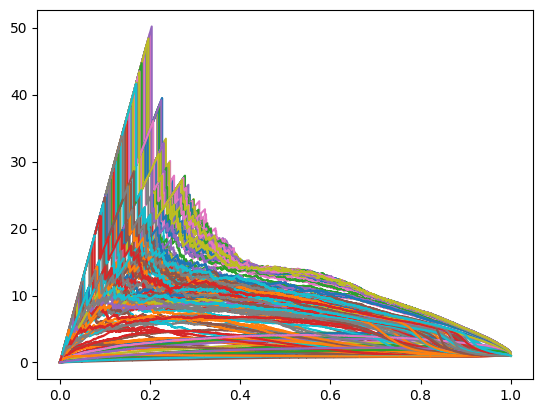

In [21]:
num_runs = 5
scores_list_runs = []

msic1_list_runs = []
msic2_list_runs = []

initial_weights_list_runs = []

initial_learning_rate = 0.05 #placeholder till callback

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=30*3, decay_rate=0.9, staircase=True
)

for _ in range(num_runs):

    xx = []
    yy = []
    zz = []
    ww = []

    msic1 = []
    msic2 = []
    
    score_list = []

    w1 = round(random.uniform(0.5, 6.0),3)
    w2 = round(random.uniform(0.5, 6.0),3)
    
    initial_weights_list_runs.append((w1, w2))
    
    for sigfrac in np.logspace(-3,-1,20):
        print(w1, w2, sigfrac)
        #sigfrac = 0.05
        if (sigfrac > 0.5):
            continue

        for l in model_all.layers:
            l.trainable=False

        inputs_hold = tf.keras.Input(shape=(1,))
        simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
        model3 = Model(inputs = inputs_hold, outputs = simple_model)

        inputs_hold2 = tf.keras.Input(shape=(1,))
        simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
        model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

        inputs_hold3 = tf.keras.Input(shape=(1,))
        simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
        model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

        inputs = tf.keras.Input(shape=(4,))
        inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
        hidden_layer_1 = model_all(inputs2)
        LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
        LLR_xs = 1.+sigfrac*LLR - sigfrac
        #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
        backtoprob = LLR_xs / (1.+LLR_xs)
        model_all2 = Model(inputs = inputs, outputs = backtoprob)
        model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule))

        m1 = 3
        m2 = 4.5

        test_set_back = int(len(x[0,0])*0.5)
        train_set_reference = int(len(x[0,0])*0.25)
        train_set_data = len(x[0,0]) - test_set_back - train_set_reference
        test_set_sig = int(len(x[m1,m2])*0.5)
        sig_frac = sigfrac

        tot = train_set_reference
        x_vals_ = np.concatenate([x[0,0][test_set_back:],x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*tot)]])
        y_vals_ = np.concatenate([np.zeros(train_set_reference),np.ones(train_set_data),np.ones(len(x[m1,m2][test_set_sig:test_set_sig+int(sig_frac*tot)]))])

        print(tot,len(x[0,0])-tot,len(x[m1,m2][0:int(sig_frac*tot)]),len(x[m1,m2][0:int(sig_frac*tot)])/tot)

        X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5, random_state = 42)

        myhistory_hack_ = model_all2.fit(X_train_[:,0:4], Y_train_, epochs=50,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024)
        print(m1,m2,model_all2.trainable_weights[0].numpy()[0][0],model_all2.trainable_weights[1].numpy()[0][0])
        xx+=[sigfrac]
        yy+=[model_all2.trainable_weights[0].numpy()[0][0]]
        zz+=[model_all2.trainable_weights[1].numpy()[0][0]]
        #ww+=[np.exp(model_all2.trainable_weights[2].numpy()[0][0])]
        scores = model_all2.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
        y = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
        fpr, tpr, _ = metrics.roc_curve(y, scores)
        
        score_list.append(scores)

        model_cwola = Sequential()
        model_cwola.add(Dense(128, input_dim=4, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(128, activation='relu'))
        model_cwola.add(Dense(1, activation='sigmoid'))
        model_cwola.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        myhistory_cwola = model_cwola.fit(X_train_[:,0:4], Y_train_, epochs=10,validation_data=(X_val_[:,0:4], Y_val_),batch_size=1024,verbose = 0)

        scores2 = model_cwola.predict(np.concatenate([x[0,0][0:test_set_back],x[m1,m2][0:test_set_sig]]),batch_size=1024)
        y2 = np.concatenate([np.zeros(test_set_back),np.ones(test_set_sig)])
        fpr2, tpr2, _ = metrics.roc_curve(y2, scores2)
        plt.plot(tpr,tpr/np.sqrt(fpr))
        plt.plot(tpr2,tpr2/np.sqrt(fpr2))

        msic1.append(np.max(tpr/np.sqrt(fpr+0.0001)))
        msic2.append(np.max(tpr2/np.sqrt(fpr2+0.0001)))
        
    msic1_list_runs.append(msic1)
    msic2_list_runs.append(msic2)
    scores_list_runs.append(score_list)

In [22]:
np.shape(score_list)

(20, 96771, 1)

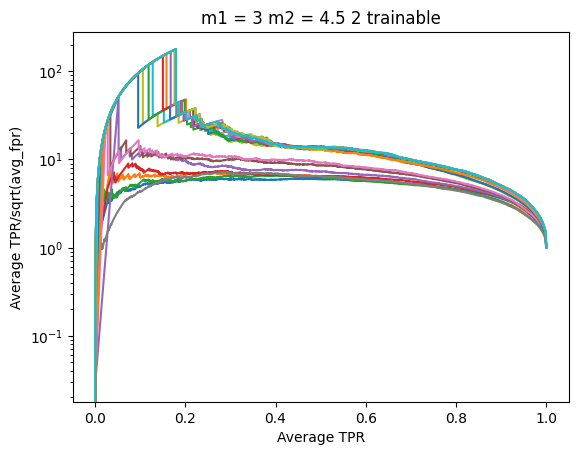

In [23]:
avg = np.mean(scores_list_runs, axis = 0)
for avg_scores in avg:
    avg_fpr, avg_tpr, _ = metrics.roc_curve(y, avg_scores)
    plt.plot(avg_tpr,avg_tpr/np.sqrt(avg_fpr + epsilon))
    plt.title(f"m1 = {m1} m2 = {m2} 2 trainable")
    plt.xlabel("Average TPR")
    plt.ylabel("Average TPR/sqrt(avg_fpr)")
plt.yscale("log")

Text(0, 0.5, 'Avg Max SIC')

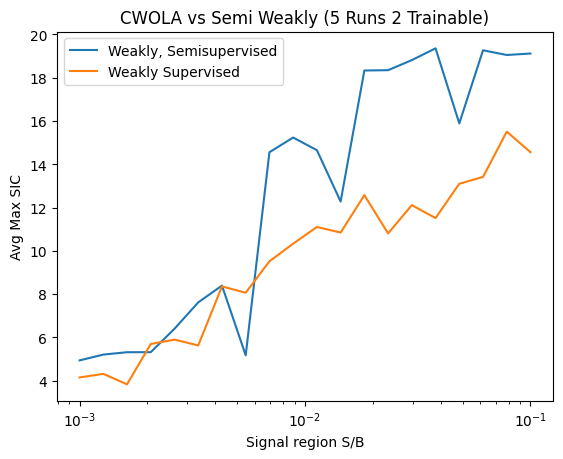

In [24]:
avgmsic1 = np.mean(msic1_list_runs, axis = 0)
avgmsic2 = np.mean(msic2_list_runs, axis = 0)

plt.plot(xx,avgmsic1,label="Weakly, Semisupervised")
plt.plot(xx,avgmsic2,label="Weakly Supervised")
plt.title("CWOLA vs Semi Weakly (5 Runs 2 Trainable)")
plt.legend()
plt.xscale("log")
plt.xlabel("Signal region S/B")
plt.ylabel("Avg Max SIC")